In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
import re

In [3]:
def get_minmax(list_transformed_bboxes):
    x_min = np.inf
    x_max = -np.inf
    y_min = np.inf
    y_max = -np.inf
    z_min = np.inf
    z_max = -np.inf

    for arr in list_transformed_bboxes:
        x_coords = arr[:, 0]
        y_coords = arr[:, 1]
        z_coords = arr[:, 2]
        
        x_min = min(x_min, np.min(x_coords))
        x_max = max(x_max, np.max(x_coords))
        y_min = min(y_min, np.min(y_coords))
        y_max = max(y_max, np.max(y_coords))
        z_min = min(z_min, np.min(z_coords))
        z_max = max(z_max, np.max(z_coords))

    return x_min, x_max, y_min, y_max, z_min, z_max

In [4]:
def random_point_in_valid_space(corners):
    x_min, y_min, z_min = corners[0]
    x_max, y_max, z_max = corners[7]
    x = np.random.uniform(x_min, x_max)
    y = np.random.uniform(y_min, y_max)
    z = np.random.uniform(z_min, z_max)
    return np.array([x, y, z])

In [5]:
def find_valid_space(df):
    x_min = df.loc[0, 'X-Min_transf']
    x_max = df.loc[0, 'X-Max_transf']
    y_min = df.loc[0, 'Y-Min_transf']
    y_max = df.loc[0, 'Y-Max_transf']
    z_min = df.loc[0, 'Z-Min_transf']
    z_max = df.loc[0, 'Z-Max_transf']

    for index, row in df.iterrows():
        if row['X-Min_transf'] < x_min:
            x_min = row['X-Min_transf']
        if row['X-Max_transf'] > x_max:
            x_max = row['X-Max_transf']
        if row['Y-Min_transf'] < y_min:
            y_min = row['Y-Min_transf']
        if row['Y-Max_transf'] > y_max:
            y_max = row['Y-Max_transf']
        if row['Z-Min_transf'] < z_min:
            z_min = row['Z-Min_transf']
        if row['Z-Max_transf'] > z_max:
            z_max = row['Z-Max_transf']

    # Add 10% to each side
    expand_box_percent = 0.10
    length = (x_max - x_min) * expand_box_percent
    width = (y_max - y_min) * expand_box_percent
    height = (z_max - z_min) * expand_box_percent
    x_min = x_min-length
    x_max = x_max+length
    y_min = y_min-width
    y_max = y_max+width
    z_min = z_min-height
    z_max = z_max+height

    # Define the corner matrix
    corners = np.array([[x_min, y_min, z_min],
                [x_min, y_min, z_max],
                [x_min, y_max, z_min],
                [x_min, y_max, z_max],
                [x_max, y_min, z_min],
                [x_max, y_min, z_max],
                [x_max, y_max, z_min],
                [x_max, y_max, z_max]])

    return corners

In [6]:
def transform_boundingbox(x_min, x_max, y_min, y_max, z_min, z_max, ox, oy, oz, xx, xy, xz, yx, yy, yz, zx, zy, zz):
    corners = np.array([[x_min, y_min, z_min],
                        [x_min, y_min, z_max],
                        [x_min, y_max, z_min],
                        [x_min, y_max, z_max],
                        [x_max, y_min, z_min],
                        [x_max, y_min, z_max],
                        [x_max, y_max, z_min],
                        [x_max, y_max, z_max]])
    
    rotation_matrix = np.array([[xx, xy, xz], [yx, yy, yz], [zx, zy, zz]])
    shift_vec = np.array([ox, oy, oz])
    rotated_corners = np.dot(corners, rotation_matrix) 
    transformed_corners = rotated_corners + shift_vec

    return transformed_corners    

In [7]:
def plot_bounding_box(ax, transformed_boundingbox, designation, label_relevant):

    # Define the edges of the bounding box
    edges = [(0, 1), (0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (2, 6), (3, 7), (4, 5), (4, 6), (5, 7), (6, 7)]

    # Plot the edges of the bounding box
    for edge in edges:
        if label_relevant == "Nein":
            ax.plot(transformed_boundingbox[edge, 0], transformed_boundingbox[edge, 1], transformed_boundingbox[edge, 2], color='#999999', alpha=0.5, ms=10)
            relevant_count = 0
        elif label_relevant == "Ja":
            ax.plot(transformed_boundingbox[edge, 0], transformed_boundingbox[edge, 1], transformed_boundingbox[edge, 2], 'r-')    
            #ax.text(transformed_boundingbox[0, 0], transformed_boundingbox[0, 1], transformed_boundingbox[0, 2], designation, color='black', fontsize=10)
            relevant_count = 1
        else:
            ax.plot(transformed_boundingbox[edge, 0], transformed_boundingbox[edge, 1], transformed_boundingbox[edge, 2], 'g--')   
            relevant_count = 0

    return relevant_count

In [8]:
def plot_vehicle(df: pd.DataFrame, add_valid_space:bool, preprocessed_data:bool, mirrored: bool):
        fig = plt.figure(figsize=(10, 20), dpi=100)

        ax = fig.add_subplot(111, projection='3d')

        # Iterate through the dataframe and plot each bounding box
        count_relevant_parts = 0
        count_all = 0

        for index, row in df.iterrows():
                if preprocessed_data:
                        transformed_boundingbox = np.array([[row['X-Min_transf'], row['Y-Min_transf'], row['Z-Min_transf']],
                                                [row['X-Min_transf'], row['Y-Min_transf'], row['Z-Max_transf']],
                                                [row['X-Min_transf'], row['Y-Max_transf'], row['Z-Min_transf']],
                                                [row['X-Min_transf'], row['Y-Max_transf'], row['Z-Max_transf']],
                                                [row['X-Max_transf'], row['Y-Min_transf'], row['Z-Min_transf']],
                                                [row['X-Max_transf'], row['Y-Min_transf'], row['Z-Max_transf']],
                                                [row['X-Max_transf'], row['Y-Max_transf'], row['Z-Min_transf']],
                                                [row['X-Max_transf'], row['Y-Max_transf'], row['Z-Max_transf']]])
                else:    
                        transformed_boundingbox = transform_boundingbox(row['X-Min'], row['X-Max'], row['Y-Min'], row['Y-Max'], row['Z-Min'], row['Z-Max'], row['ox'], row['oy'], row['oz'], row['xx'], row['xy'], row['xz'], row['yx'], row['yy'], row['yz'], row['zx'], row['zy'], row['zz'])
                relevant = plot_bounding_box(ax, transformed_boundingbox, row['Benennung (dt)'], row["Relevant fuer Messung"])
                count_relevant_parts = count_relevant_parts + relevant
                count_all = count_all + 1

        if add_valid_space:
                corners = find_valid_space(df.reset_index(drop=True))
                plot_bounding_box(ax, corners, 'Valid Space', 'space')

        print(f"{count_relevant_parts} relevant parts found")
        print(f"Still {count_all-count_relevant_parts} not relevant parts found")

        # Set axis labels
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        # Set axis limits
        ax.set_xlim(-2000, 5000)
        ax.set_ylim(-1500, 1500)
        ax.set_zlim(-100, 1500)
        
        ax.set_aspect('equal', adjustable='box')

        if mirrored:
                ax.invert_xaxis()

        plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.savefig("../plots_images/bounding_boxes/bounding_box_G65_step00.png", format='png', bbox_inches='tight', pad_inches=0)

        # Show the plot
        plt.show()    

In [9]:
def calculate_center_point(transf_bbox):
    sum_X = 0
    sum_Y = 0
    sum_Z = 0
    num_corners = len(transf_bbox)
    for xyz in transf_bbox:
        sum_X = sum_X + xyz[0]
        sum_Y = sum_Y + xyz[1]
        sum_Z = sum_Z + xyz[2]
    
    center_x = sum_X/num_corners
    center_y = sum_Y/num_corners
    center_z = sum_Z/num_corners

    return center_x, center_y, center_z

In [10]:
def calculate_lwh(transformed_boundingbox):
    x = []
    y = []
    z = []

    for xyz in transformed_boundingbox:
        x.append(xyz[0])  
        y.append(xyz[1])  
        z.append(xyz[2])   

    length = max(x) - min(x) 
    width = max(y) - min(y) 
    height = max(z) - min(z) 
    
    return length, width, height

In [11]:
def calculate_orientation(transformed_boundingbox):
    # Center the corners around the origin
    centered_corners = transformed_boundingbox - np.mean(transformed_boundingbox, axis=0) 

    # The function uses Singular Value Decomposition (SVD) to find the principal axes of the bounding box. SVD is a procedure that decomposes a matrix into three matrices: an orthogonal matrix U, a diagonal matrix S, and another orthogonal matrix V. The diagonal entries of S are the singular values of the matrix, which represent the size of the principal axes.
    u, s, principal_axes = np.linalg.svd(centered_corners)

    # Convert the principal axes to Euler angles
    theta_x = np.arctan2(principal_axes[2, 1], principal_axes[2, 2])
    theta_y = np.arctan2(-principal_axes[2, 0], np.sqrt(principal_axes[2, 1]**2 + principal_axes[2, 2]**2))
    theta_z = np.arctan2(principal_axes[1, 0], principal_axes[0, 0])

    return theta_x, theta_y, theta_z

In [12]:
def add_new_features(df):
    for index, row in df.iterrows():  
        # Calculate and add new features to represent the bounding boxes
        transformed_boundingbox = transform_boundingbox(row['X-Min'], row['X-Max'], row['Y-Min'], row['Y-Max'], row['Z-Min'], row['Z-Max'],row['ox'],row['oy'],row['oz'],row['xx'],row['xy'],row['xz'],row['yx'],row['yy'],row['yz'],row['zx'],row['zy'],row['zz'])
        center_x, center_y, center_z = calculate_center_point(transformed_boundingbox)
        length, width, height = calculate_lwh(transformed_boundingbox)
        theta_x, theta_y, theta_z = calculate_orientation(transformed_boundingbox)

        x_coords = transformed_boundingbox[:, 0]
        y_coords = transformed_boundingbox[:, 1]
        z_coords = transformed_boundingbox[:, 2]

        df.at[index, 'X-Min_transf'] = min(x_coords)
        df.at[index, 'X-Max_transf'] = max(x_coords)
        df.at[index, 'Y-Min_transf'] = min(y_coords)
        df.at[index, 'Y-Max_transf'] = max(y_coords)
        df.at[index, 'Z-Min_transf'] = min(z_coords)
        df.at[index, 'Z-Max_transf'] = max(z_coords)   
        df.at[index, 'center_x'] = center_x
        df.at[index, 'center_y'] = center_y
        df.at[index, 'center_z'] = center_z
        df.at[index, 'length'] = length
        df.at[index, 'width'] = width
        df.at[index, 'height'] = height
        df.at[index, 'theta_x'] = theta_x
        df.at[index, 'theta_y'] = theta_y
        df.at[index, 'theta_z'] = theta_z

        # Calculate and add the volume as new feature 
        volume = length * width * height
        df.at[index, 'volume'] = volume

        # If weight is availabe, calculate and add the density as new feature 
        if pd.notnull(row['Wert']) and volume != 0:
            density = row['Wert'] / volume
            df.at[index, 'density'] = density
        
    df.loc[df['Wert'].isnull(), ['Wert']] = 0
    df.loc[df['density'].isnull(), ['density']] = 0
        
    return df

In [13]:
def prepare_text(designation: str) -> str:
    # transform to lower case
    text = str(designation).upper()

    # Removing punctations
    text = re.sub(r"[^\w\s]", "", text)

    # Removing numbers
    text = ''.join([i for i in text if not i.isdigit()])

    # tokenize text
    text = text.split(" ")

    # Remove predefined words
    predefined_words = ["ZB", "AF", "LI", "RE", "MD", "LL", "TAB", "TB"]
    if len(predefined_words) > 0:
        text = [word for word in text if word not in predefined_words]

    # Remove words with only one letter
    text = [word for word in text if len(word) > 1]

    # remove empty tokens
    text = [t for t in text if len(t) > 0]

    # join all
    prepared_designation = " ".join(text)

    return prepared_designation

In [14]:
def clean_text(df):
    df["Benennung (bereinigt)"] = df.apply(lambda x: prepare_text(x["Benennung (dt)"]), axis=1)

    return df

In [15]:
def preprocess_dataset(df, cut_percent_of_front: float):
    logger.info(f"Start preprocessing the dataframe with {df.shape[0]} samples...")

    df.loc[df['X-Max'] == 10000, ['X-Min', 'X-Max', 'Y-Min', 'Y-Max', 'Z-Min', 'Z-Max', 'ox', 'oy', 'oz', 'xx', 'xy', 'xz', 'yx', 'yy', 'yz', 'zx', 'zy', 'zz', 'Wert']] = 0

    df_new_features = add_new_features(df)

    # Using dictionary to convert specific columns
    convert_dict = {'X-Min': float,
                    'X-Max': float,
                    'Y-Min': float,
                    'Y-Max': float,
                    'Z-Min': float,
                    'Z-Max': float,
                    'Wert': float,
                    'ox': float,
                    'oy': float,
                    'oz': float,
                    'xx': float,
                    'xy': float,
                    'xz': float,
                    'yx': float,
                    'yy': float,
                    'yz': float,
                    'zx': float,
                    'zy': float,
                    'zz': float                     
                    }
    
    df_new_features = df_new_features.astype(convert_dict)

    df_new_features = df_new_features[(df_new_features['X-Min'] != 0) & (df_new_features['X-Max'] != 0)]

    # Save the samples without/wrong bounding box information in a new df, as they will need to be added back later
    df_temp = df[(df["X-Min"] == 0.0) & (df["X-Max"] == 0.0)]

    # Delete all samples which have less volume than 500,000 mm^3
    df_relevants = df_new_features[(df_new_features['volume'] > 500000)].reset_index(drop=True)

    # Delete all samples where the parts are in the front area of the car
    x_min_transf, x_max_transf = df_relevants["X-Min_transf"].min(), df_relevants["X-Max_transf"].max()
    car_length = x_max_transf - x_min_transf
    cut_point_x = x_min_transf + car_length*cut_percent_of_front
    df_relevants = df_relevants[df_relevants["X-Min_transf"] > cut_point_x]

    # Concatenate the two data frames vertically
    df_relevants = pd.concat([df_relevants, df_temp]).reset_index(drop=True)

    df_relevants = clean_text(df_relevants)

    # Drop the mirrored car parts (on the right sight) which have the same Sachnummer
    df_relevants = df_relevants[~((df_relevants['Sachnummer'].duplicated(keep='last')) & (df_relevants['yy'] == -1))]

    # Drop the mirrored car parts (on the right sight) which have not the same Sachnummer 
    df_relevants = df_relevants.loc[~(df_relevants.duplicated(subset='Kurzname', keep=False) & (df_relevants['L/R-Kz.'] == 'R'))]

    df_for_plot = df_relevants[(df_relevants['X-Min'] != 0) & (df_relevants['X-Max'] != 0)]

    #df_relevants = df_relevants.loc[:,["Sachnummer", "Benennung (bereinigt)", "X-Min_transf", "X-Max_transf", "Y-Min_transf", "Y-Max_transf", "Z-Min_transf", "Z-Max_transf", "center_x", "center_y", "center_z", "length", "width", "height", "theta_x", "theta_y", "theta_z", "volume", "density", "Benennung (dt)", "Wert", "Relevant fuer Messung", "Einheitsname"]]

    # Reset the index of the merged data frame
    df_relevants = df_relevants.reset_index(drop=True)

    logger.success(f"The dataset is successfully preprocessed. The new dataset contains {df_relevants.shape[0]} samples")

    return df_relevants, df_for_plot

# Main

In [20]:
def main(path, plot_preprocessed_data: bool):
    df = pd.read_excel(path,index_col=0) 

    if plot_preprocessed_data:
        df = df[(df['X-Max'] != 0) & (df['X-Min'] != 0)]
        df = df[df["Relevant fuer Messung"] == "Ja"]
        unique_names = df["Einheitsname"].unique().tolist()
        unique_names.sort()
        for name in unique_names:
            print(name)
            df_new = df[(df["Einheitsname"] == name)]
            plot_vehicle(df_new, add_valid_space=True, preprocessed_data=False, mirrored=False)
    else:
        df_preprocessed, df_for_plot = preprocess_dataset(df, cut_percent_of_front=0.20)
        plot_vehicle(df_for_plot, add_valid_space=True, preprocessed_data=False, mirrored=False)

BLENDE HBL
3 relevant parts found
Still 0 not relevant parts found


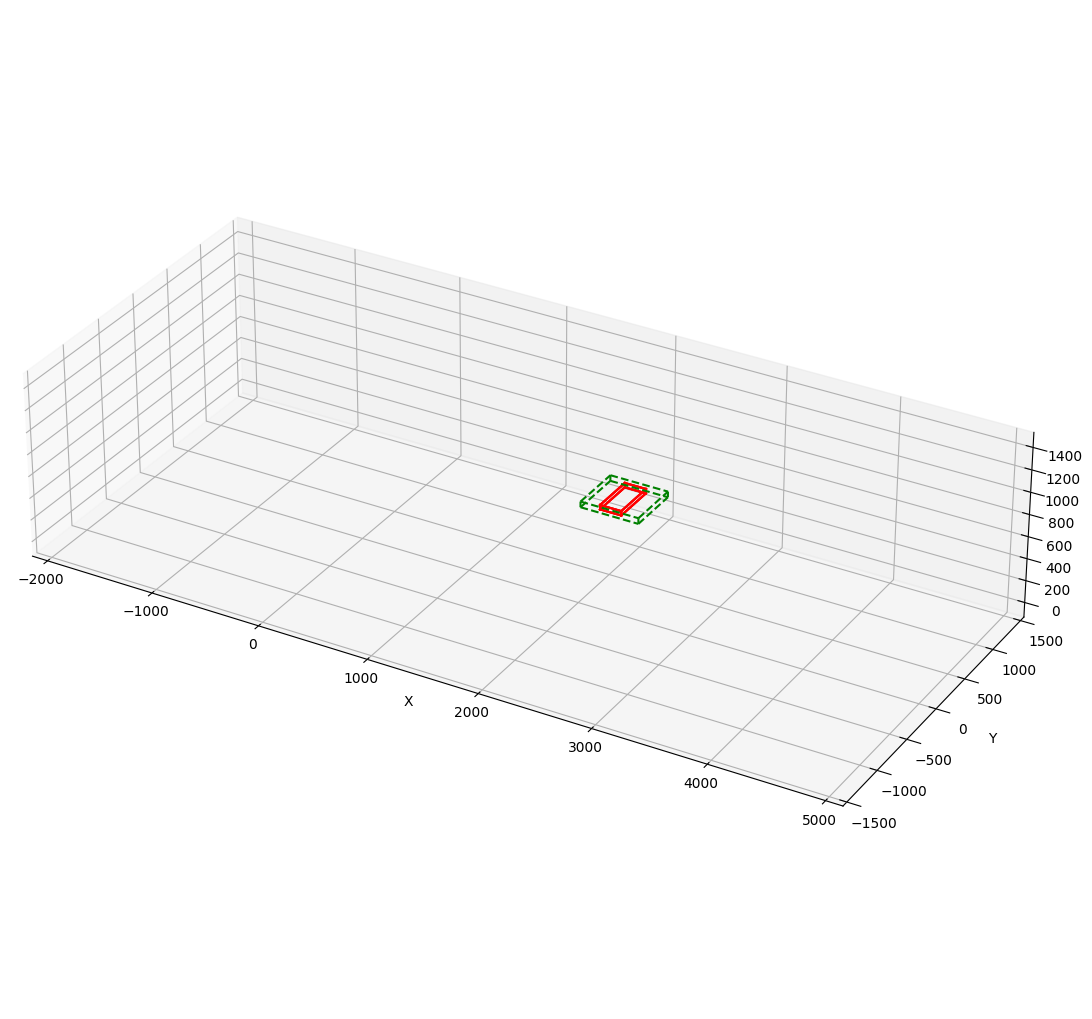

BLENDE LADEKANTE
7 relevant parts found
Still 0 not relevant parts found


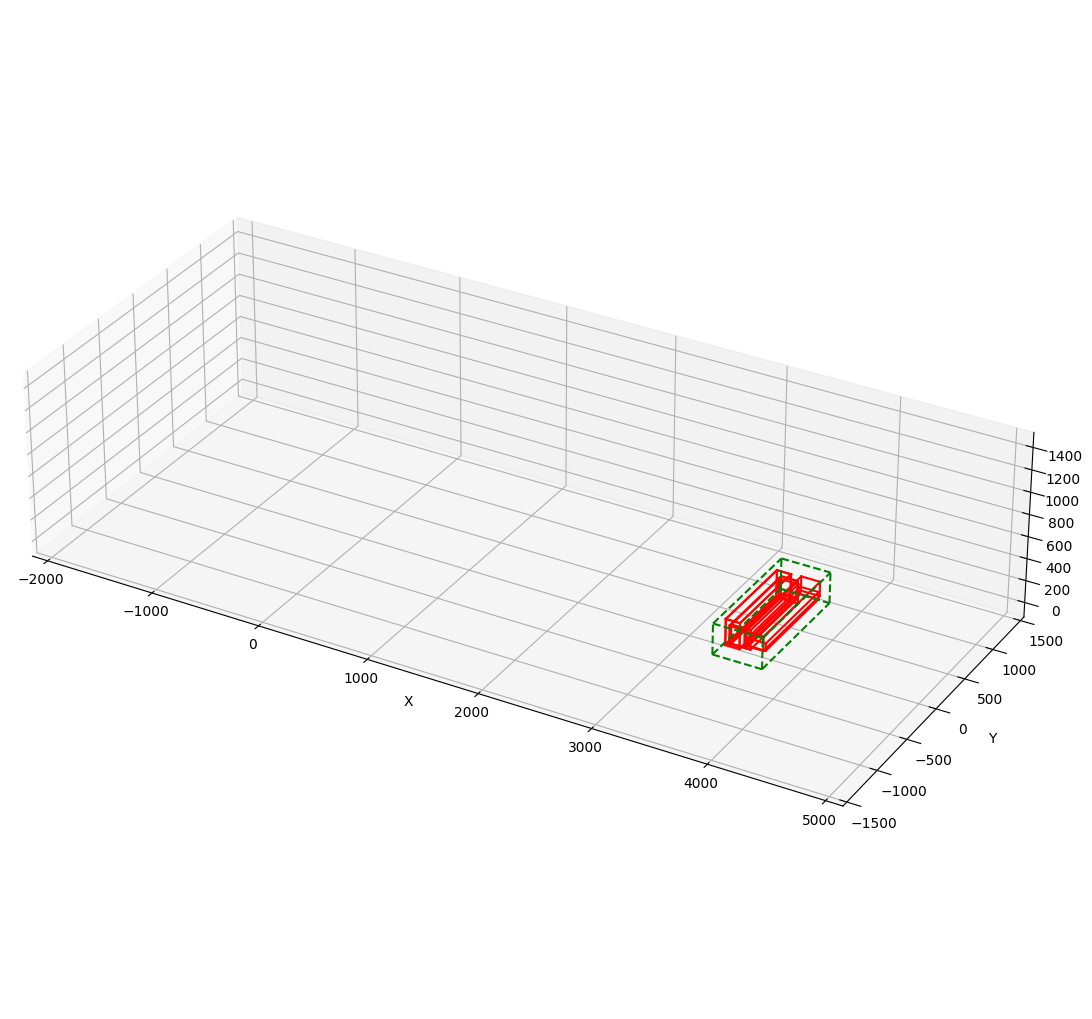

DACHANTENNE
4 relevant parts found
Still 0 not relevant parts found


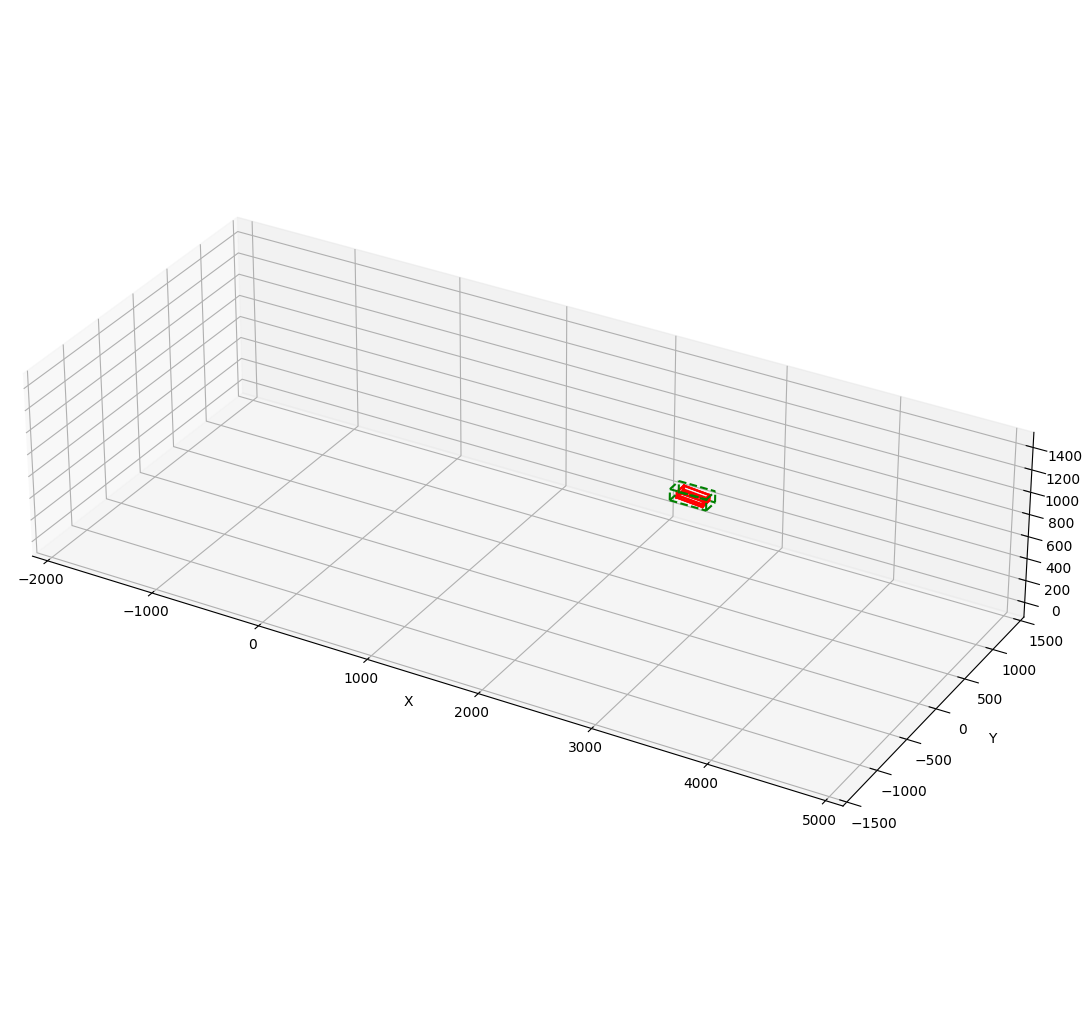

DACHAUSSENHAUT
4 relevant parts found
Still 0 not relevant parts found


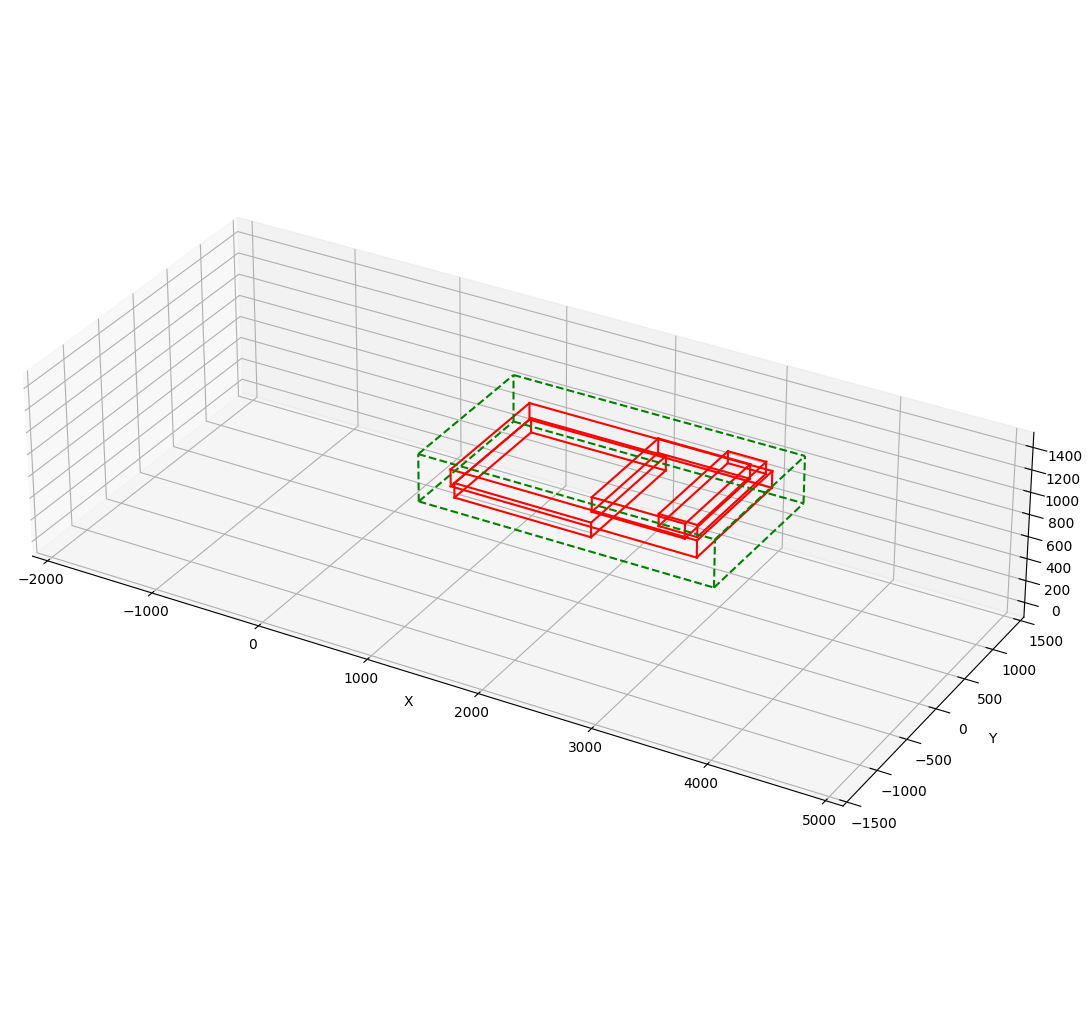

DICHTUNG HECKKLAPPE
7 relevant parts found
Still 0 not relevant parts found


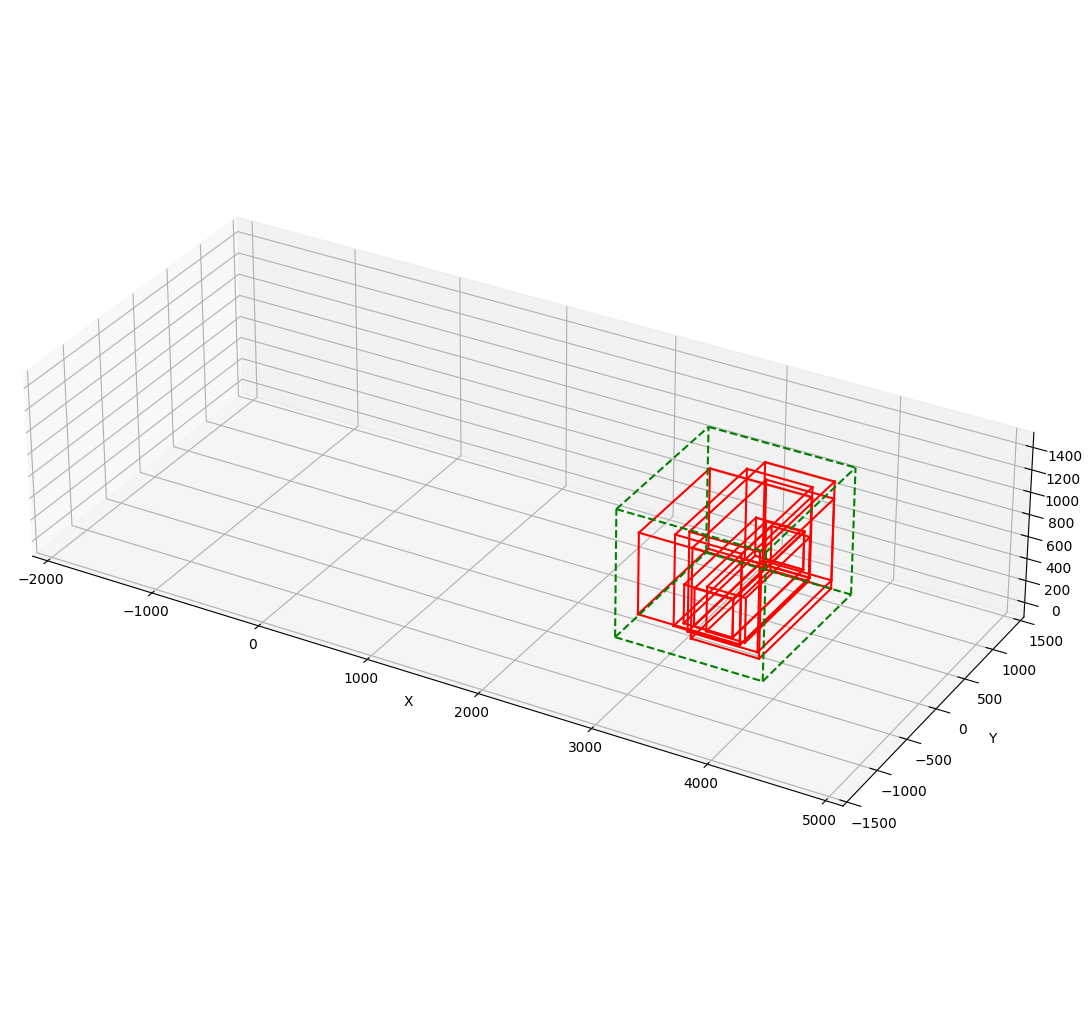

EINLEGEBODEN GEPAECKRAUM
7 relevant parts found
Still 0 not relevant parts found


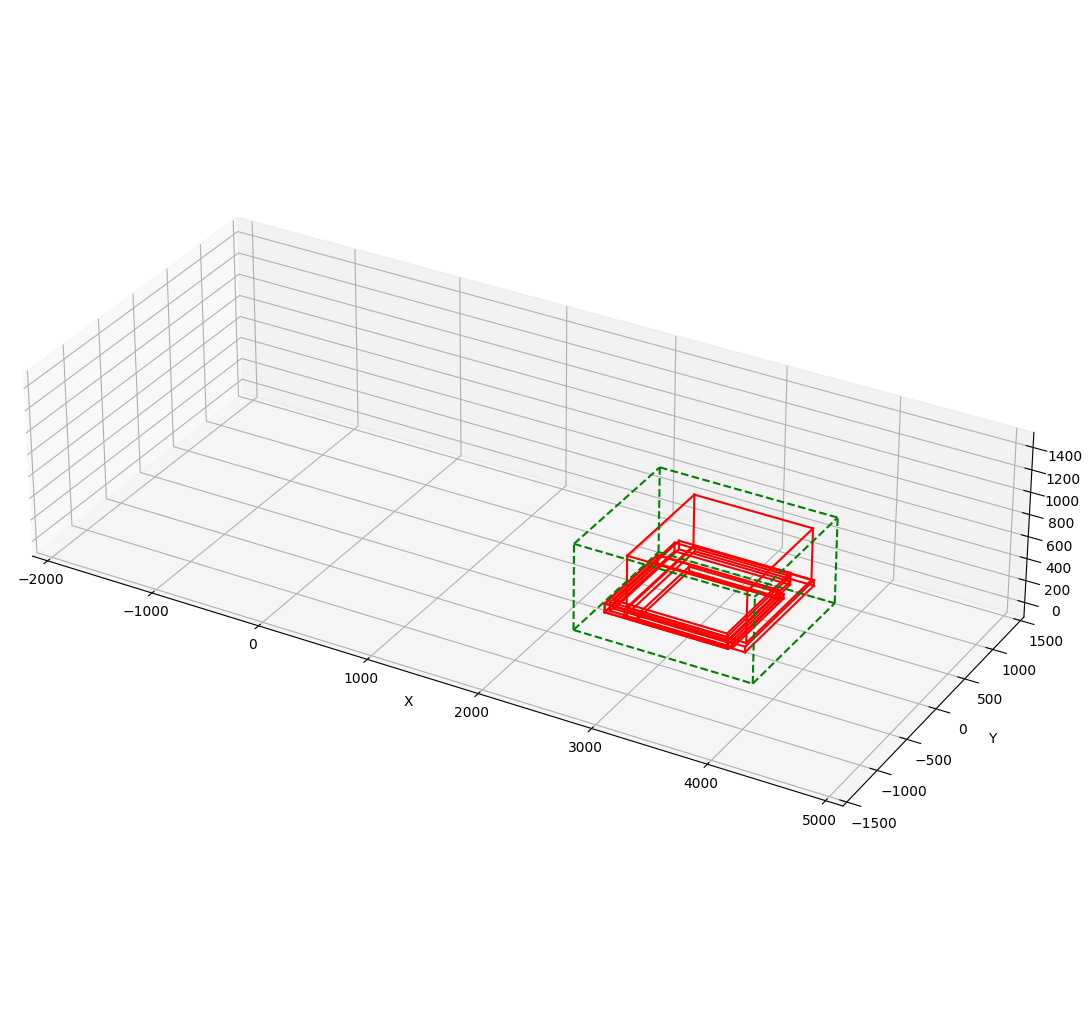

FRONTSCHEIBE
6 relevant parts found
Still 0 not relevant parts found


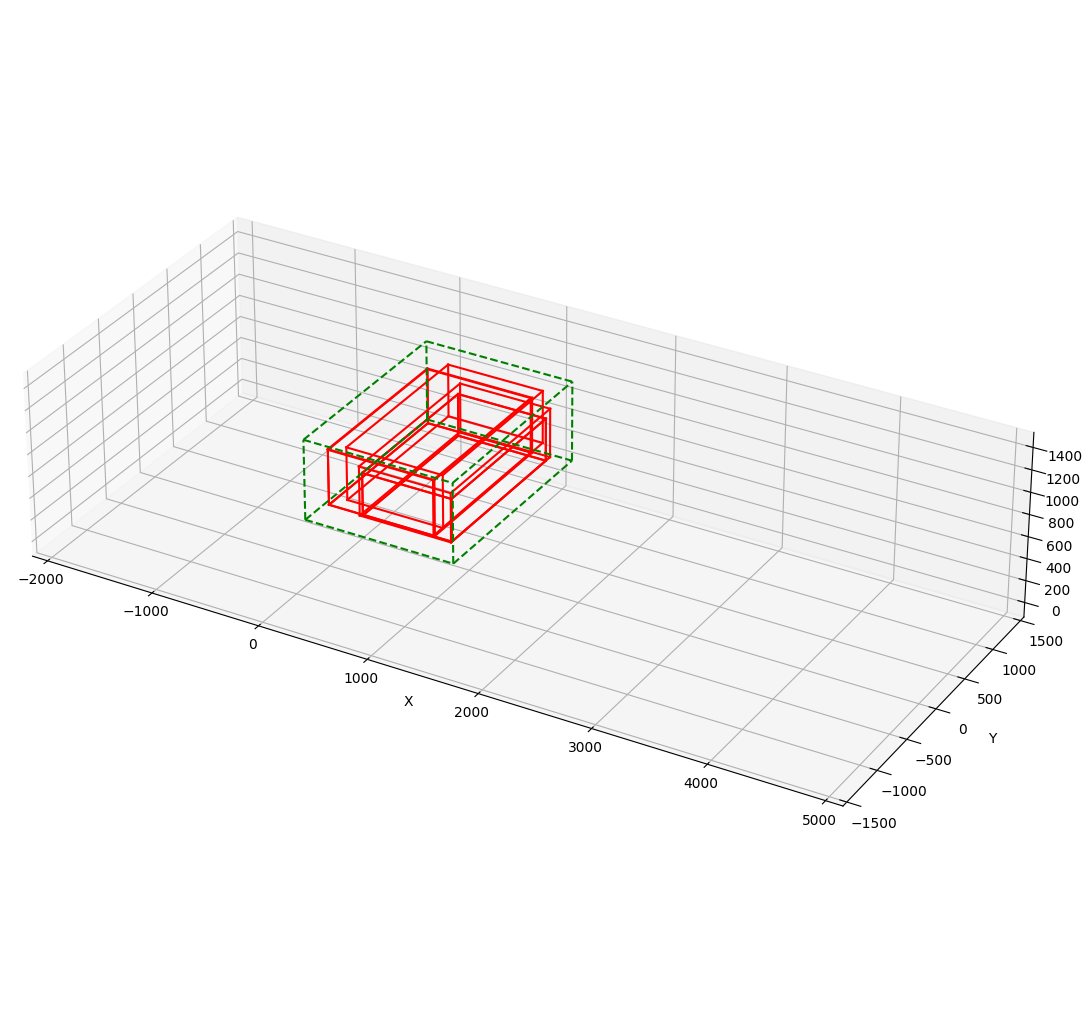

GLASDACH (SA)
3 relevant parts found
Still 0 not relevant parts found


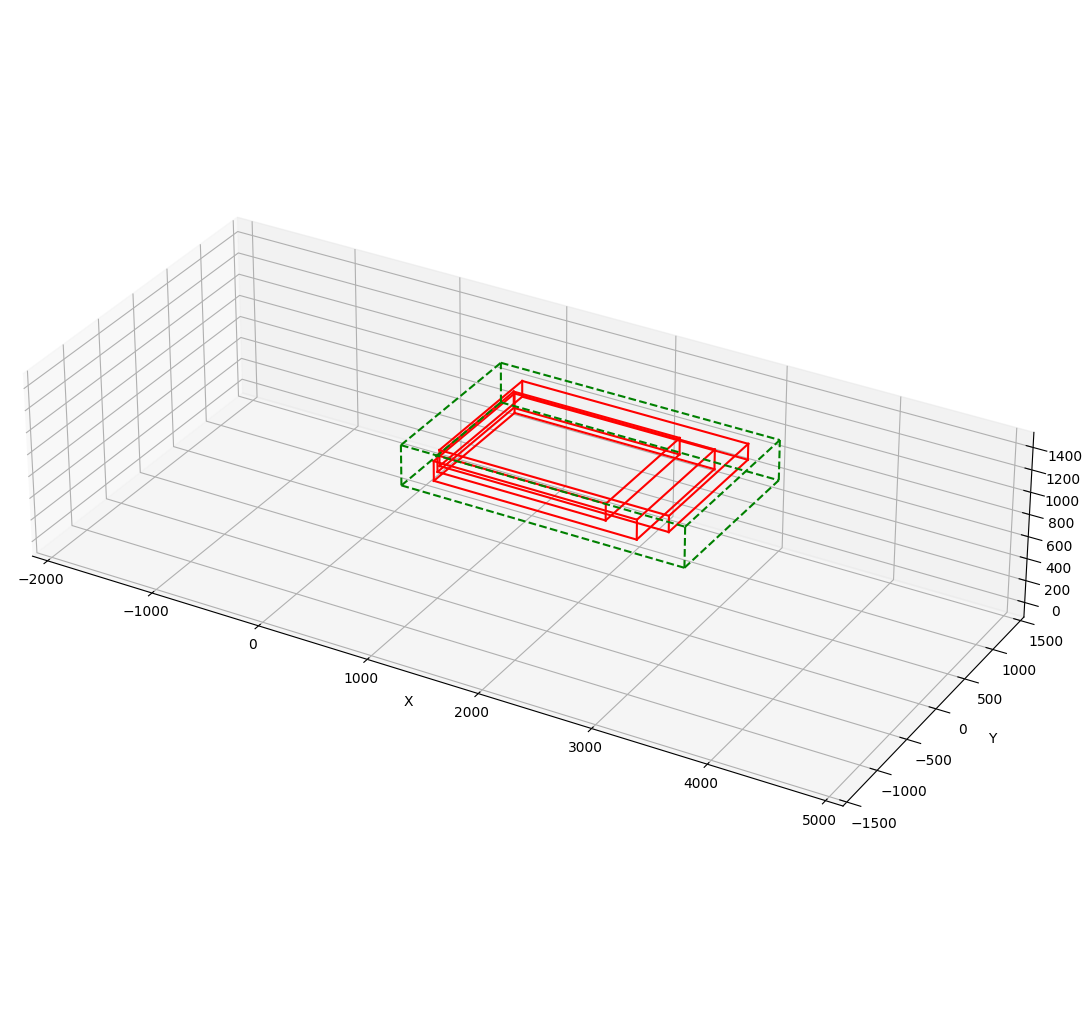

HBL
7 relevant parts found
Still 0 not relevant parts found


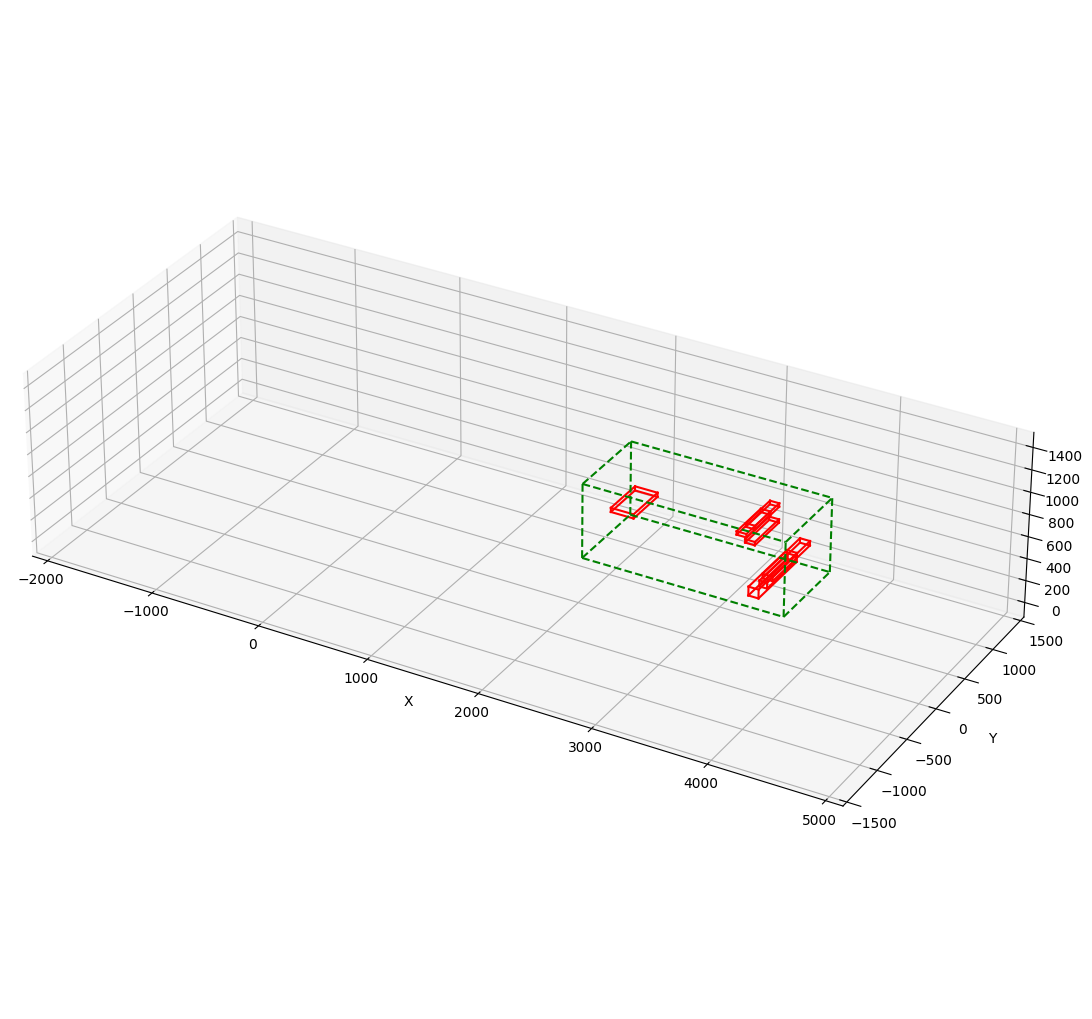

HECKKLAPPE AUSSENHAUT
6 relevant parts found
Still 0 not relevant parts found


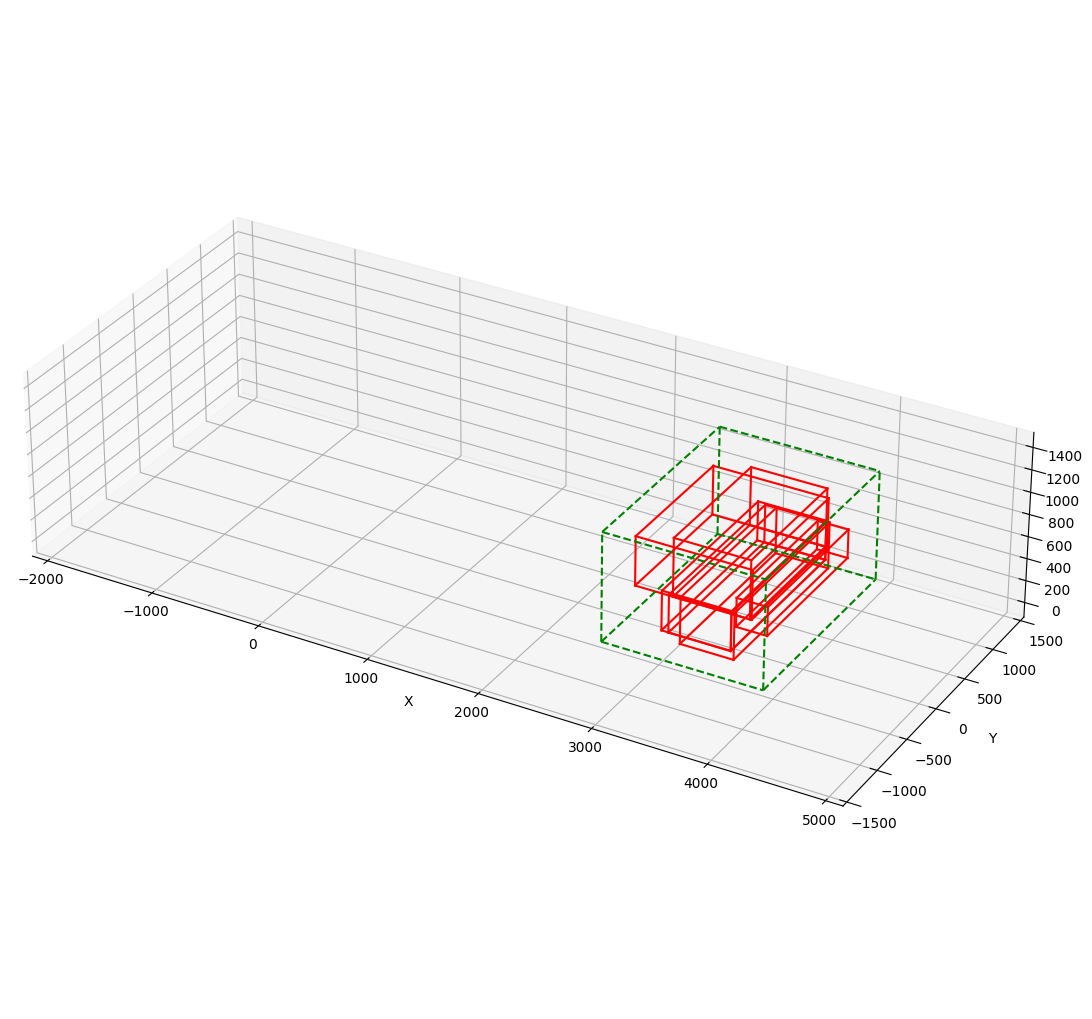

HECKSCHEIBE
5 relevant parts found
Still 0 not relevant parts found


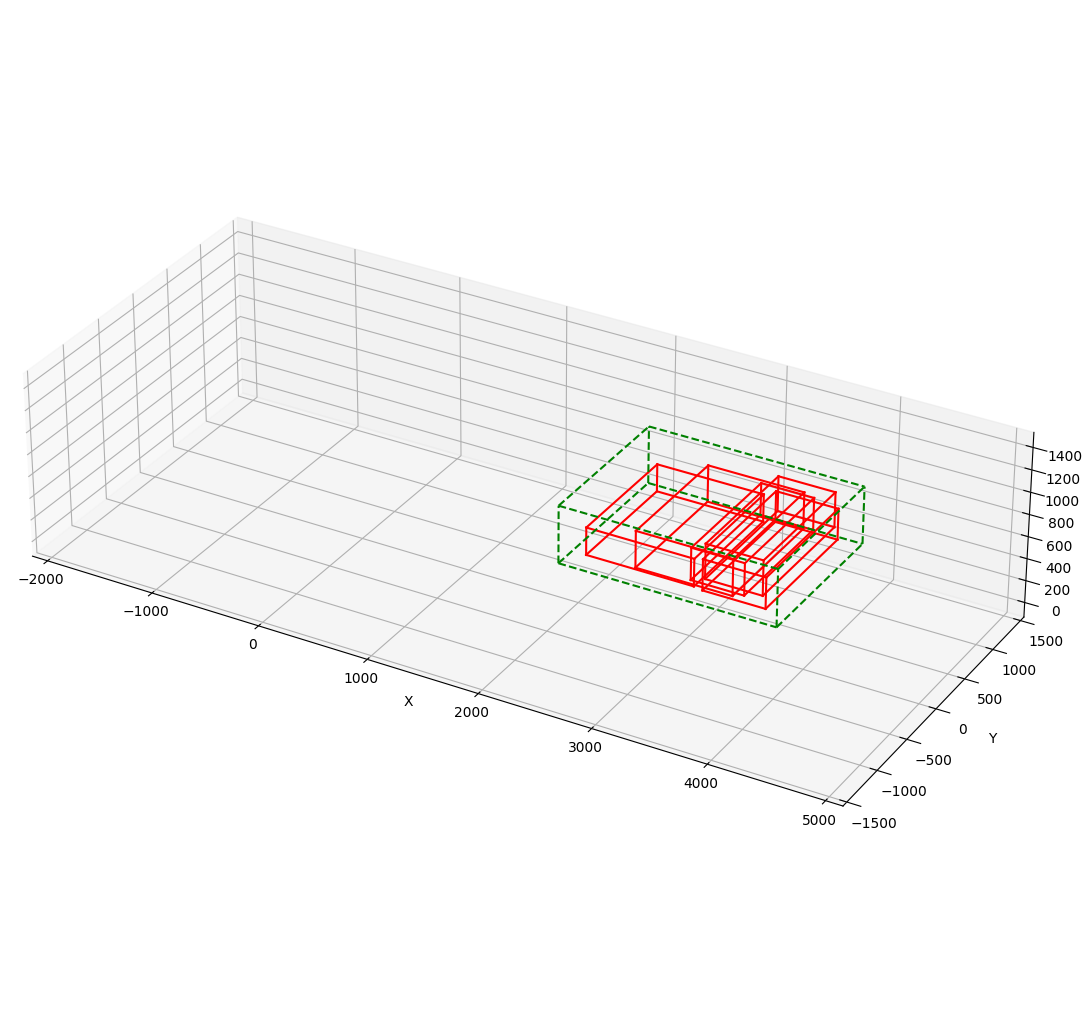

HIMMEL (SA)
7 relevant parts found
Still 0 not relevant parts found


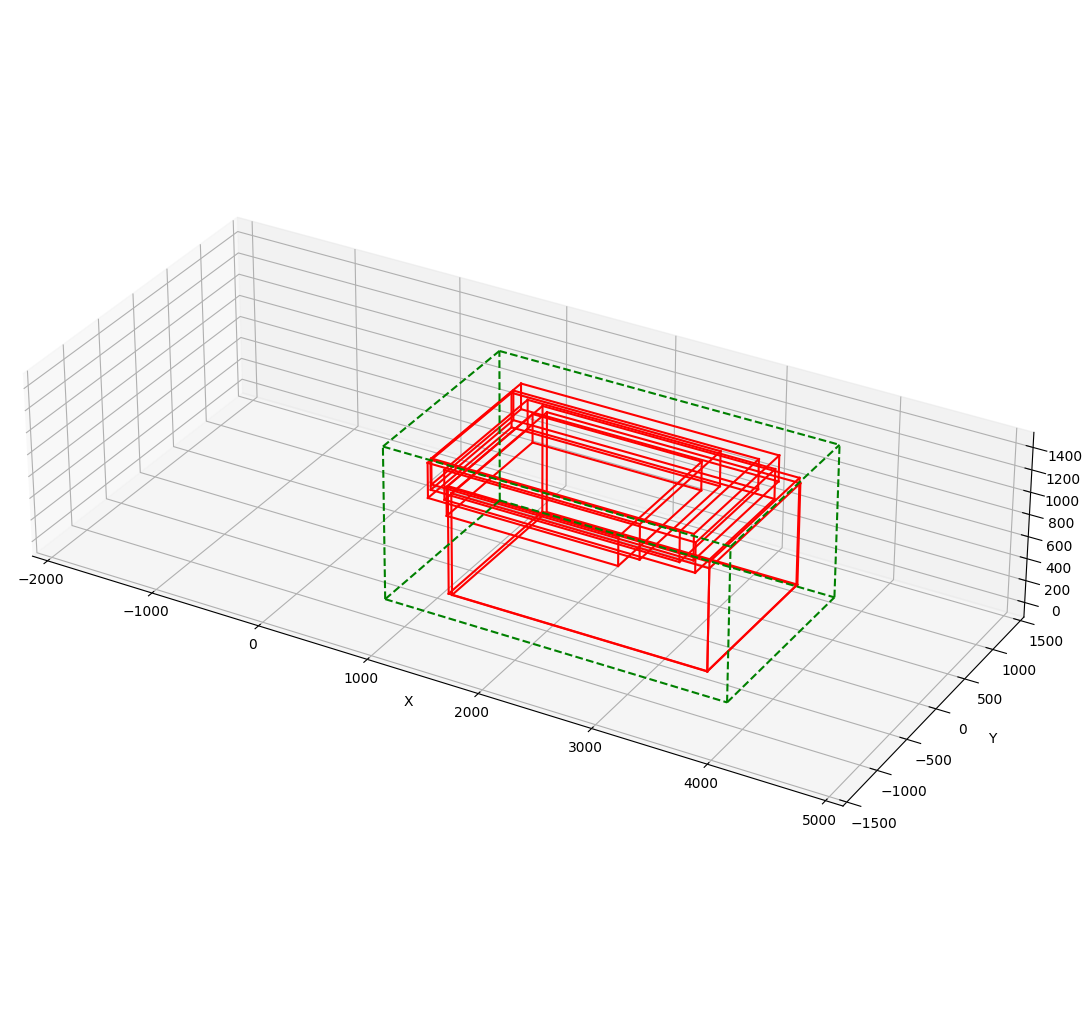

INNENSPIEGEL
7 relevant parts found
Still 0 not relevant parts found


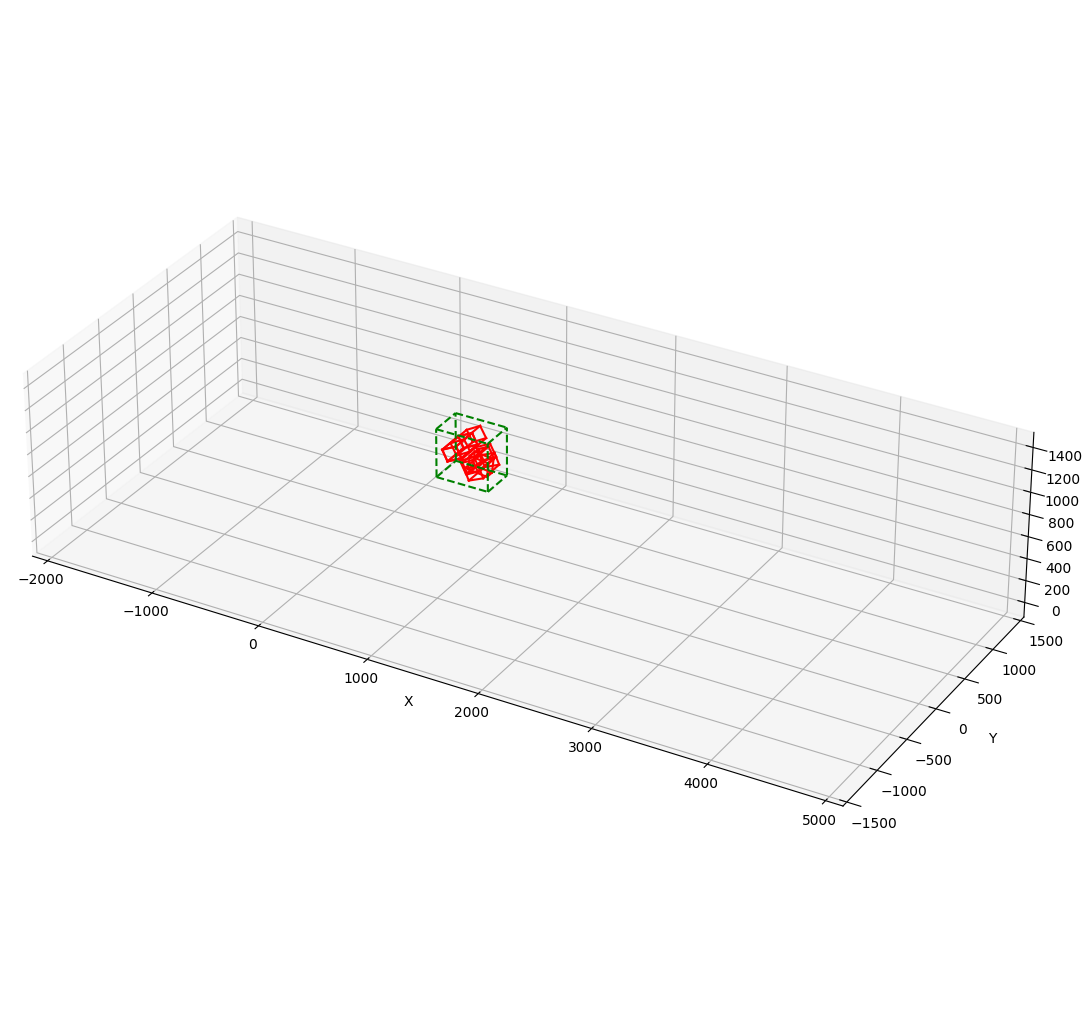

KOPFSTUETZE_MITTE_HINTEN
4 relevant parts found
Still 0 not relevant parts found


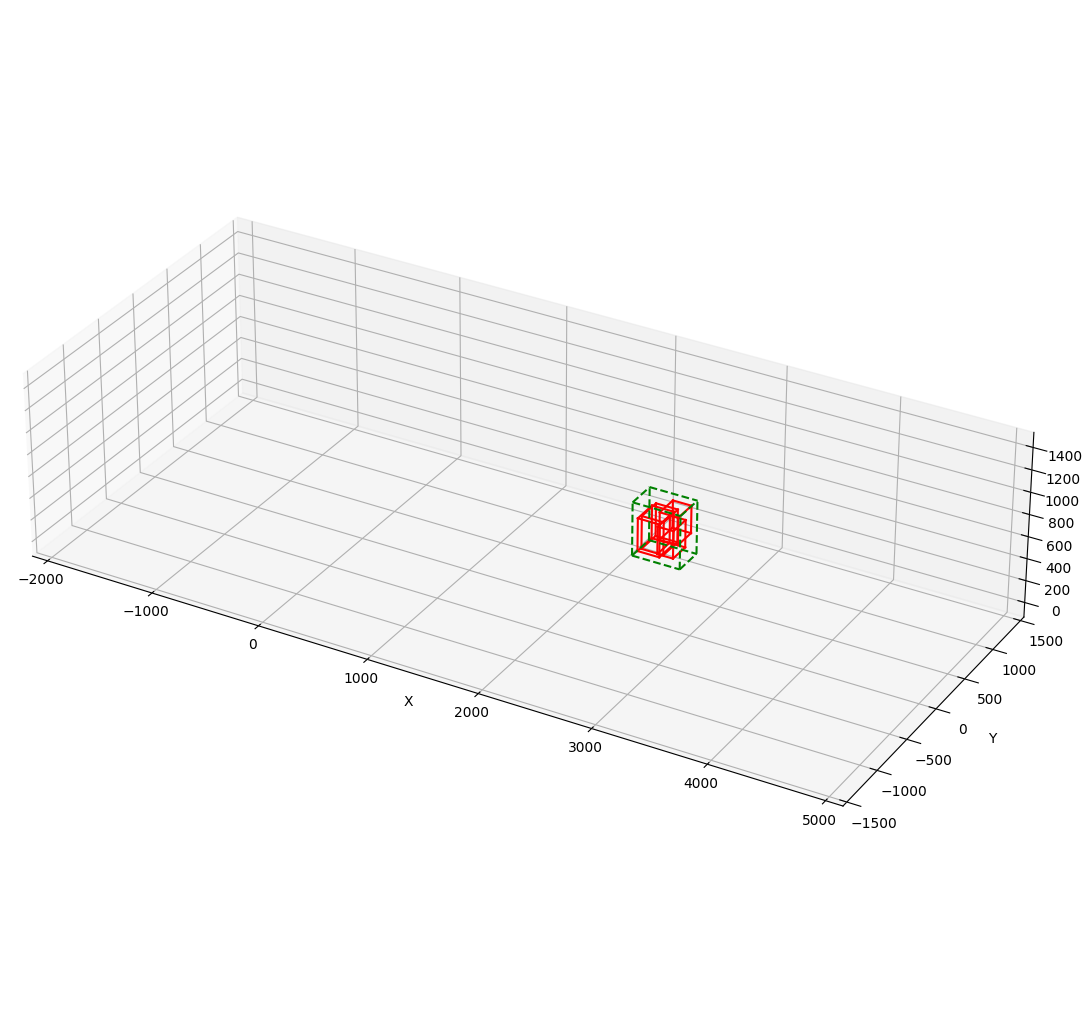

LI ABDECKLEISTE EINSTIEG HINTEN
4 relevant parts found
Still 0 not relevant parts found


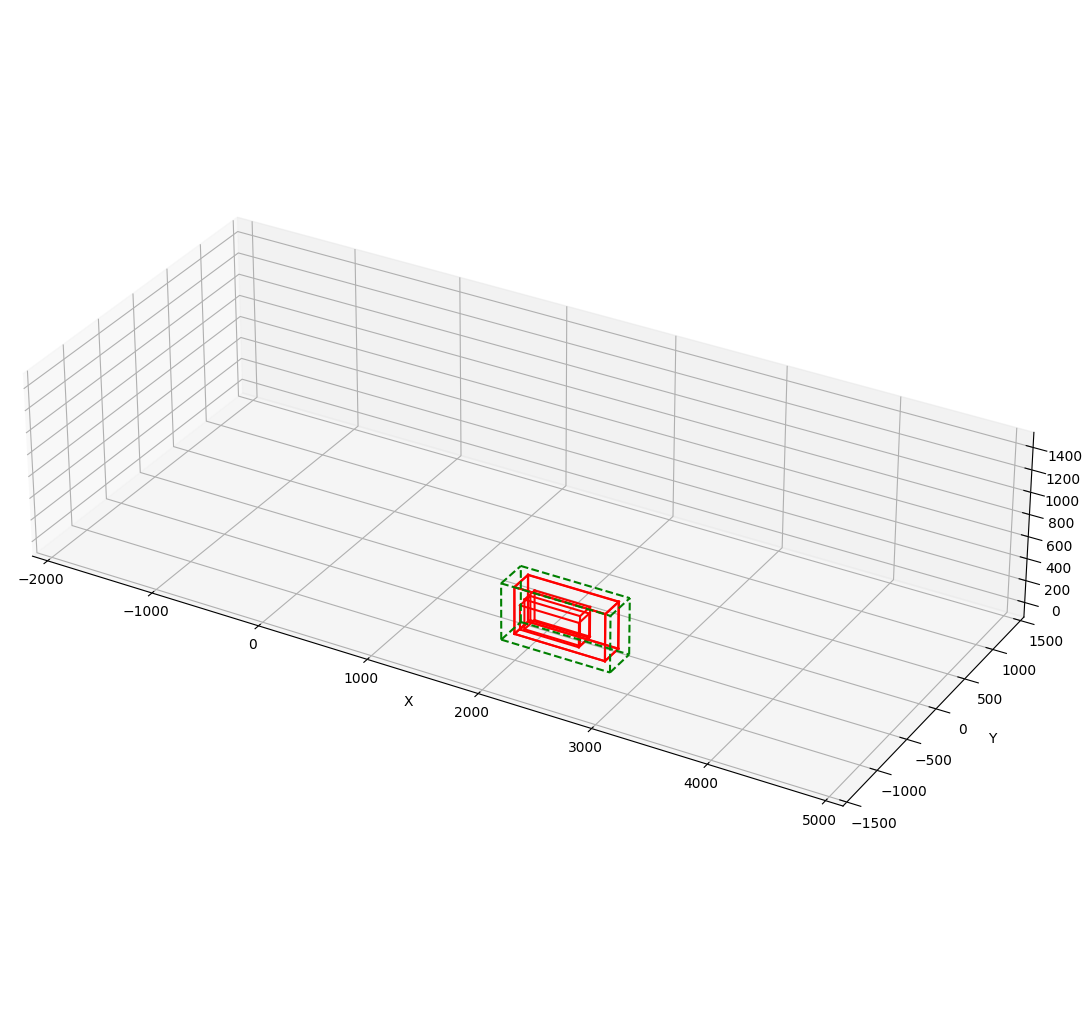

LI ABDECKUNG FENSTERRAHMEN HINTEN
4 relevant parts found
Still 0 not relevant parts found


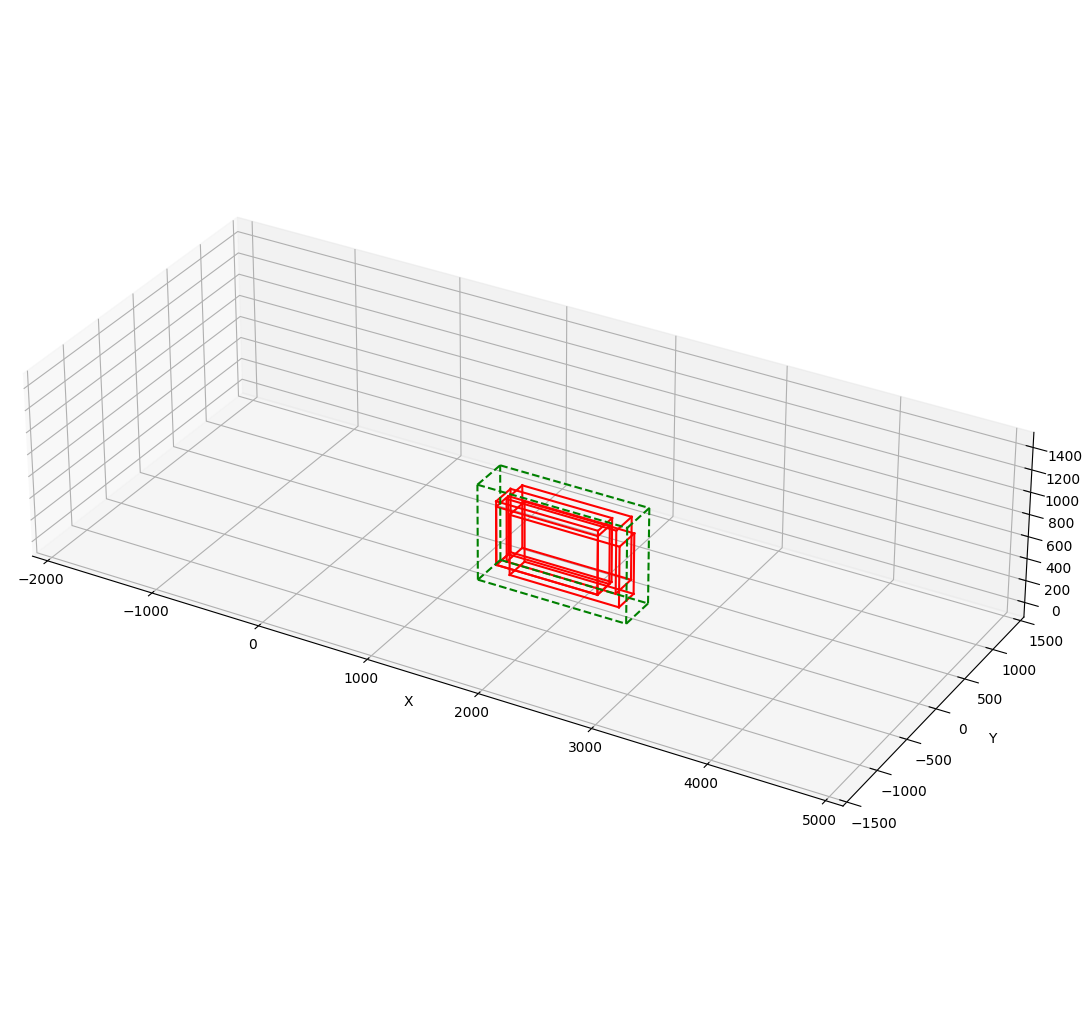

LI ABDECKUNG FENSTERRAHMEN VORNE
4 relevant parts found
Still 0 not relevant parts found


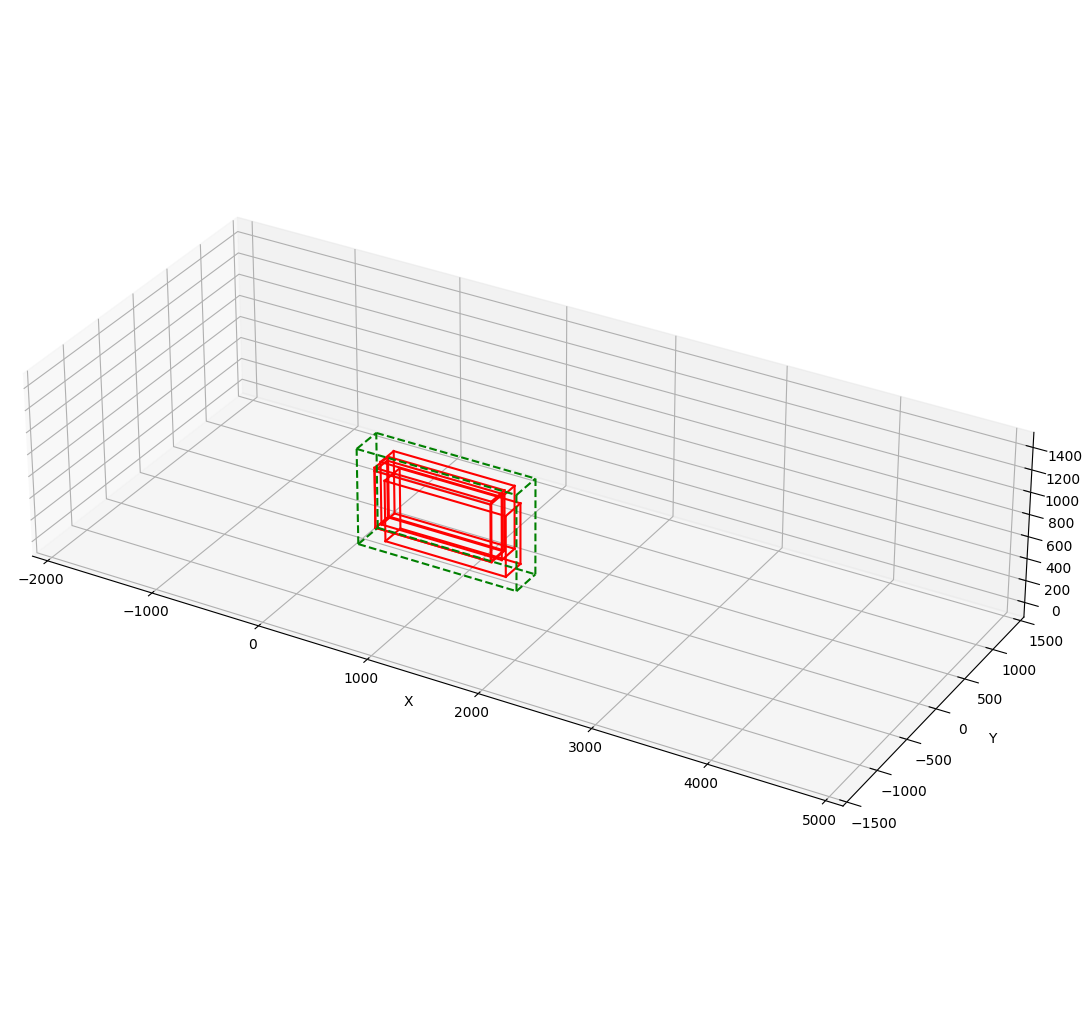

LI BLENDE A-SAEULE
11 relevant parts found
Still 0 not relevant parts found


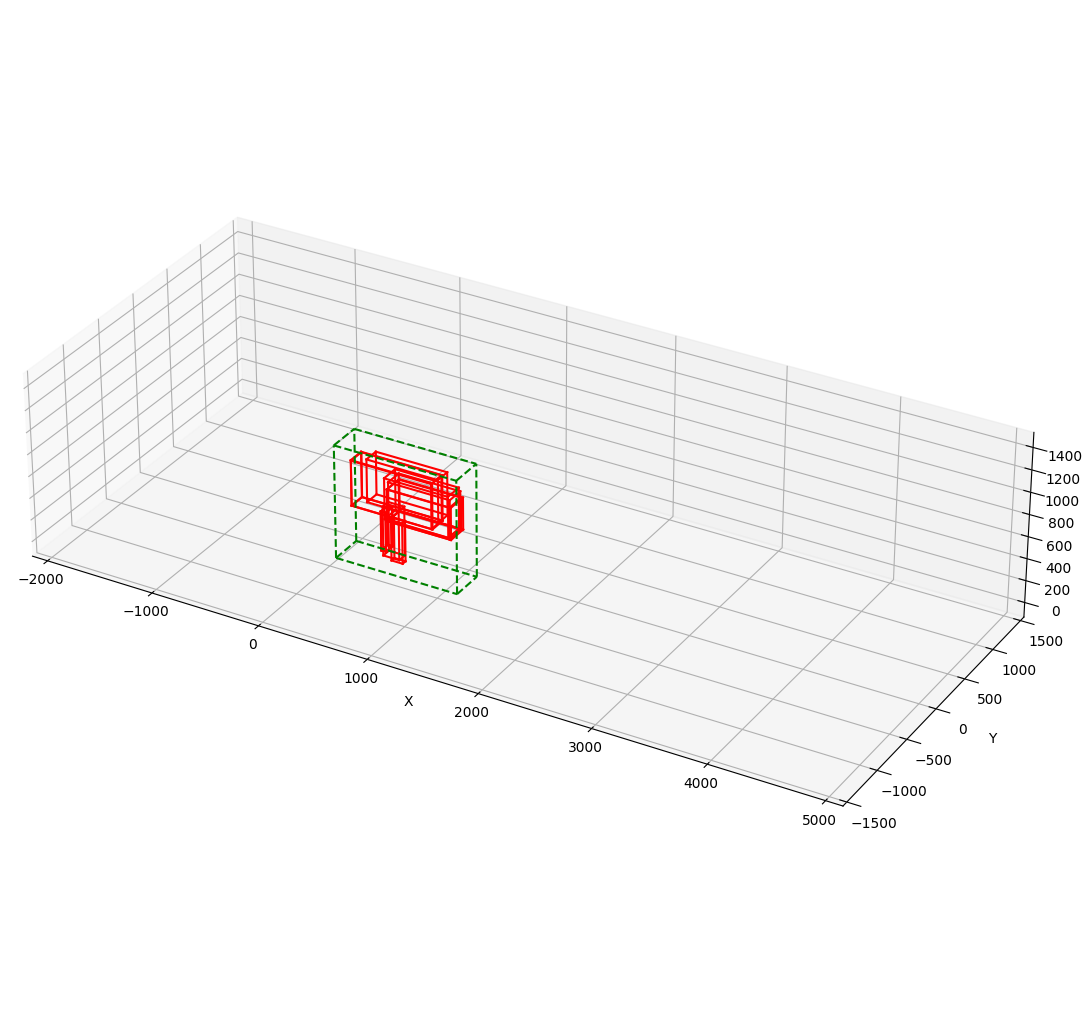

LI FENSTERFUEHRUNG
11 relevant parts found
Still 0 not relevant parts found


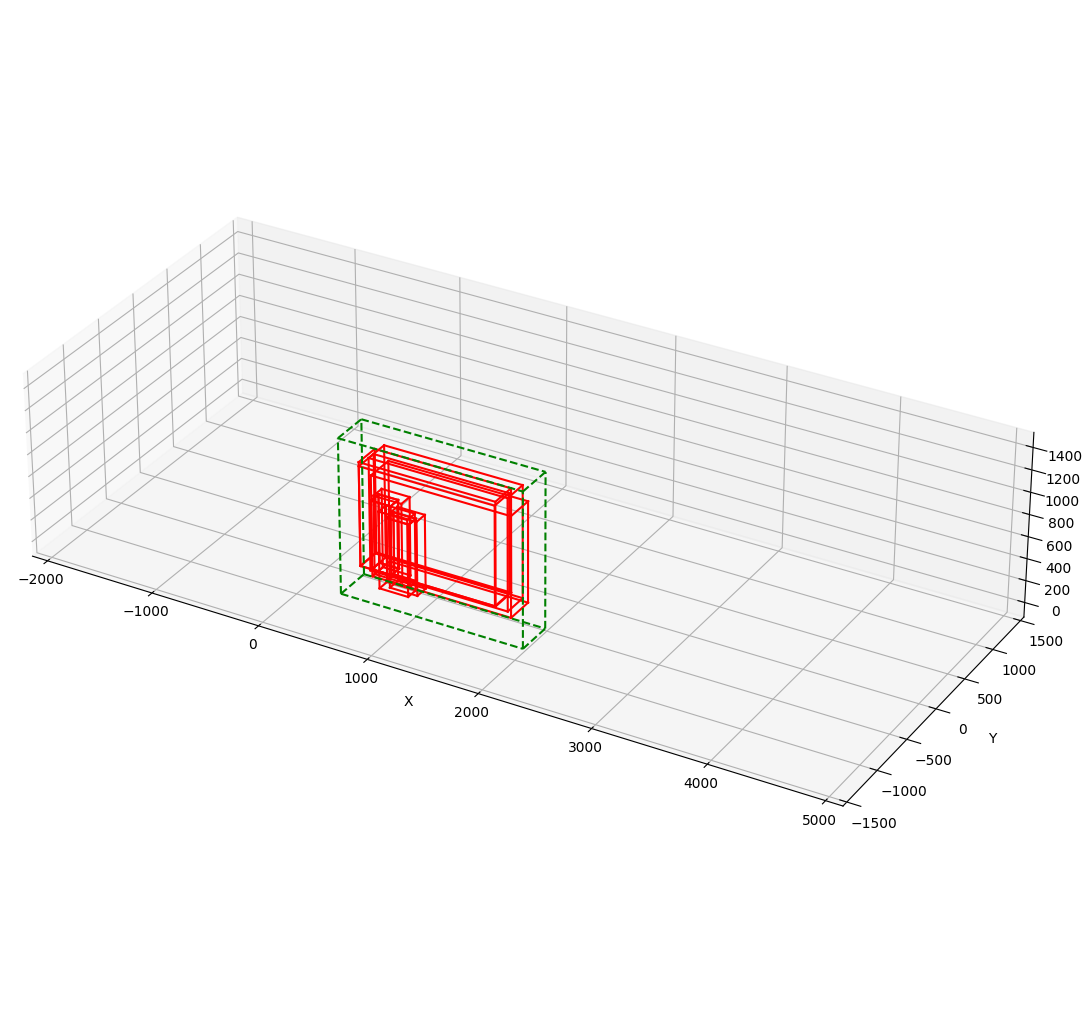

LI HALTEGRIFF HINTEN
4 relevant parts found
Still 0 not relevant parts found


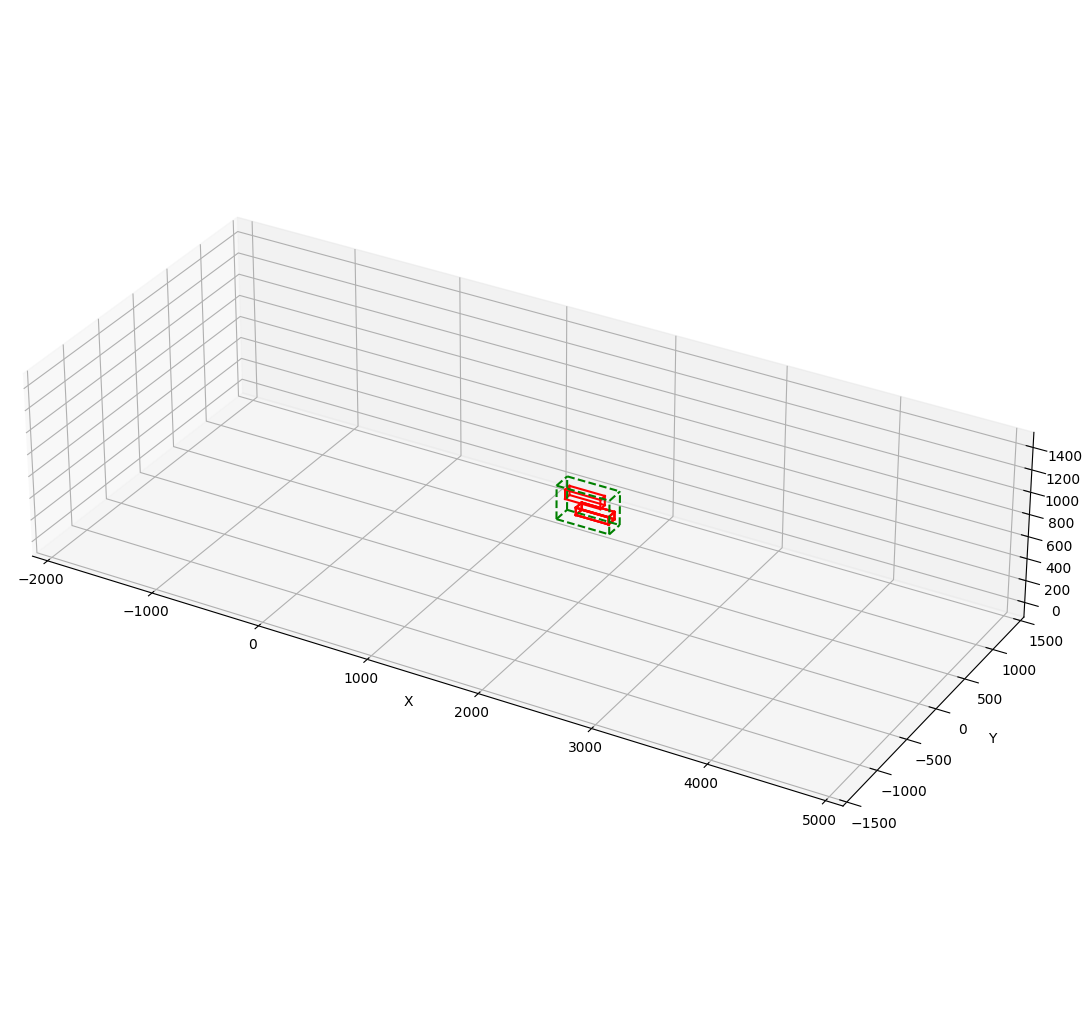

LI HALTEGRIFF VORNE
3 relevant parts found
Still 0 not relevant parts found


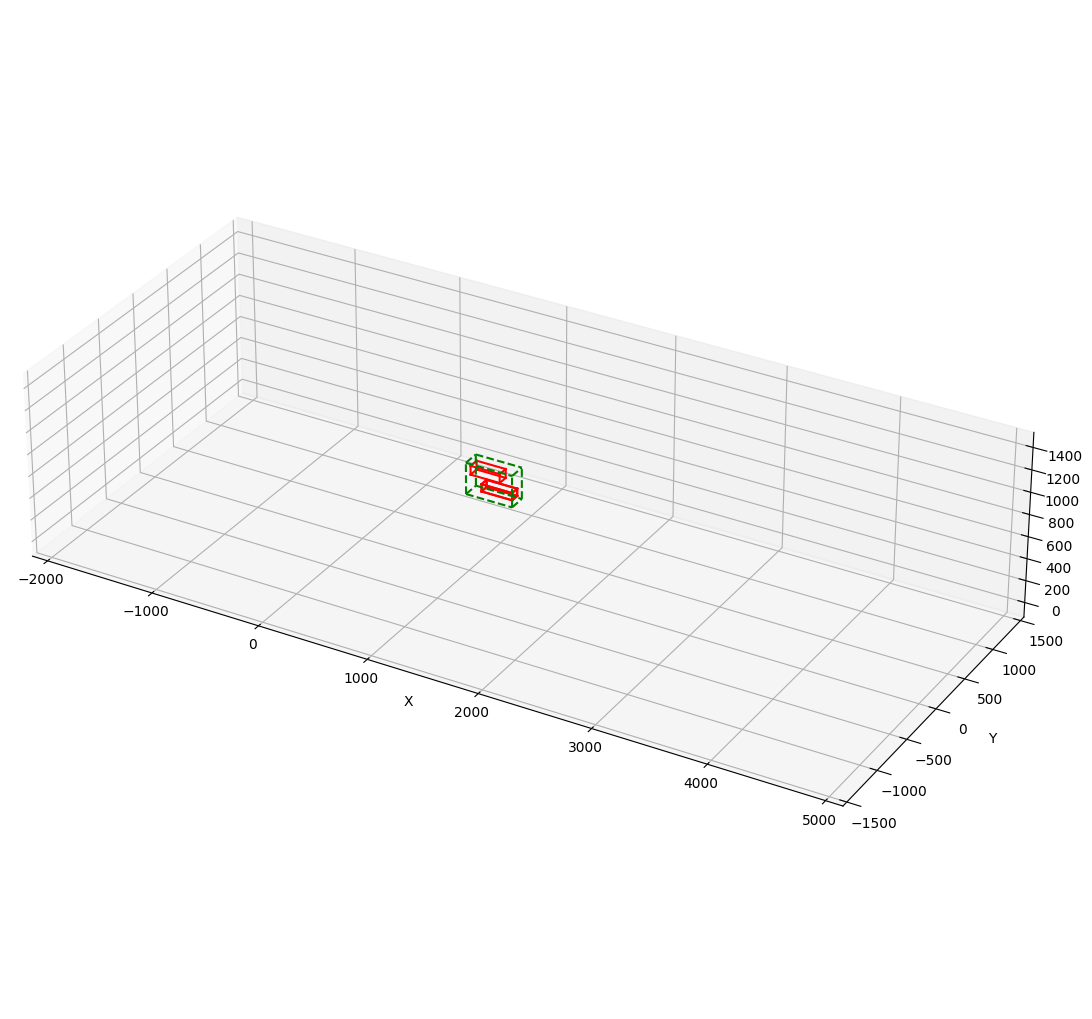

LI KANTENSCHUTZ HINTEN
3 relevant parts found
Still 0 not relevant parts found


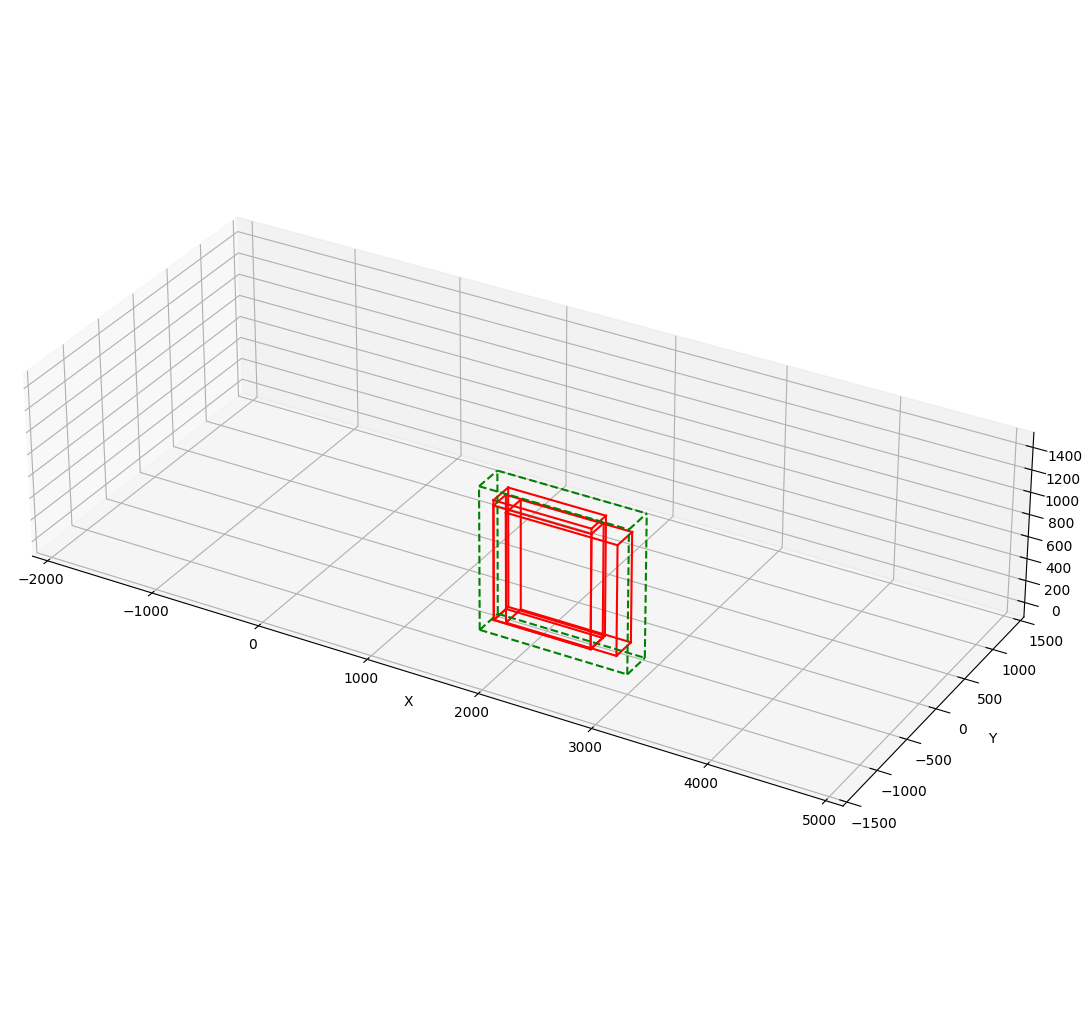

LI KANTENSCHUTZ VORNE
5 relevant parts found
Still 0 not relevant parts found


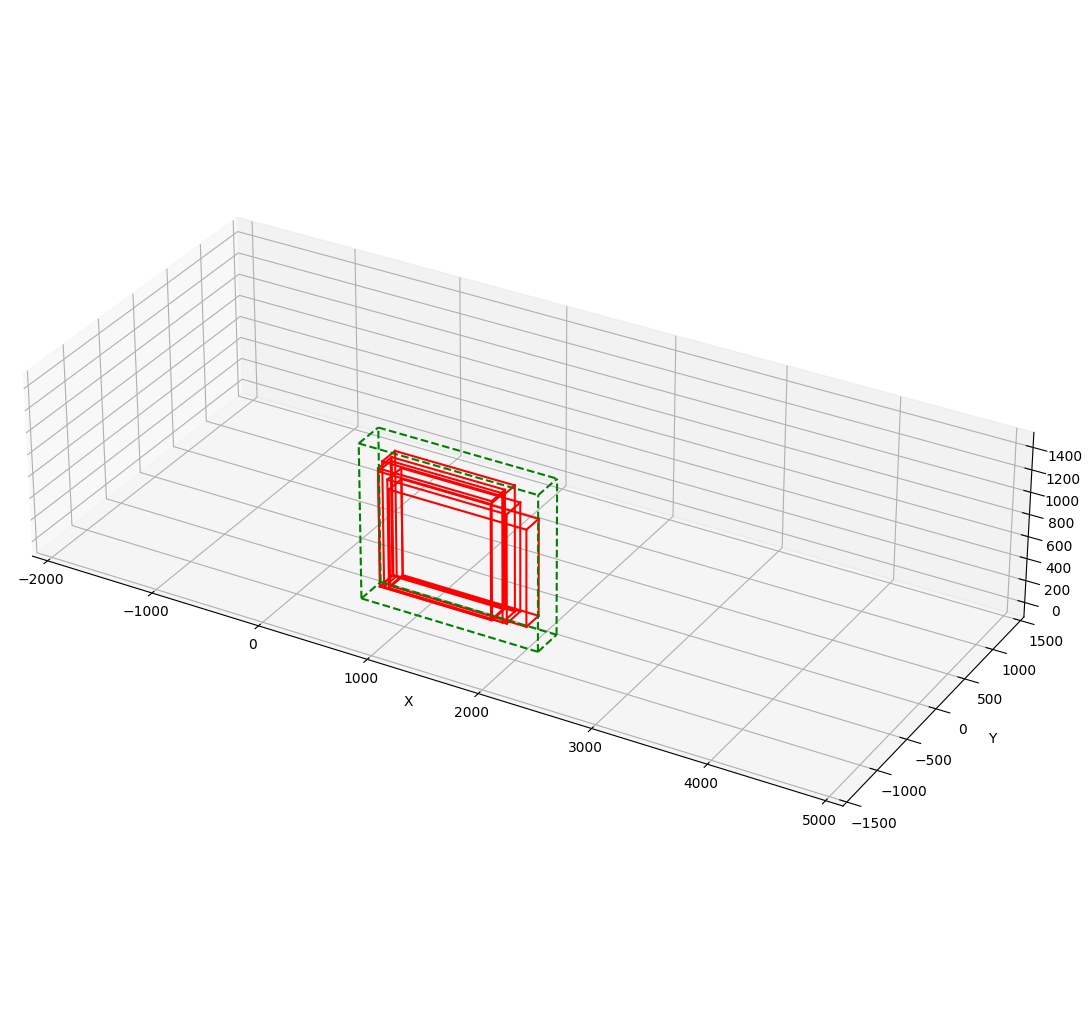

LI SEITENVERKLEIDUNG VORNE
7 relevant parts found
Still 0 not relevant parts found


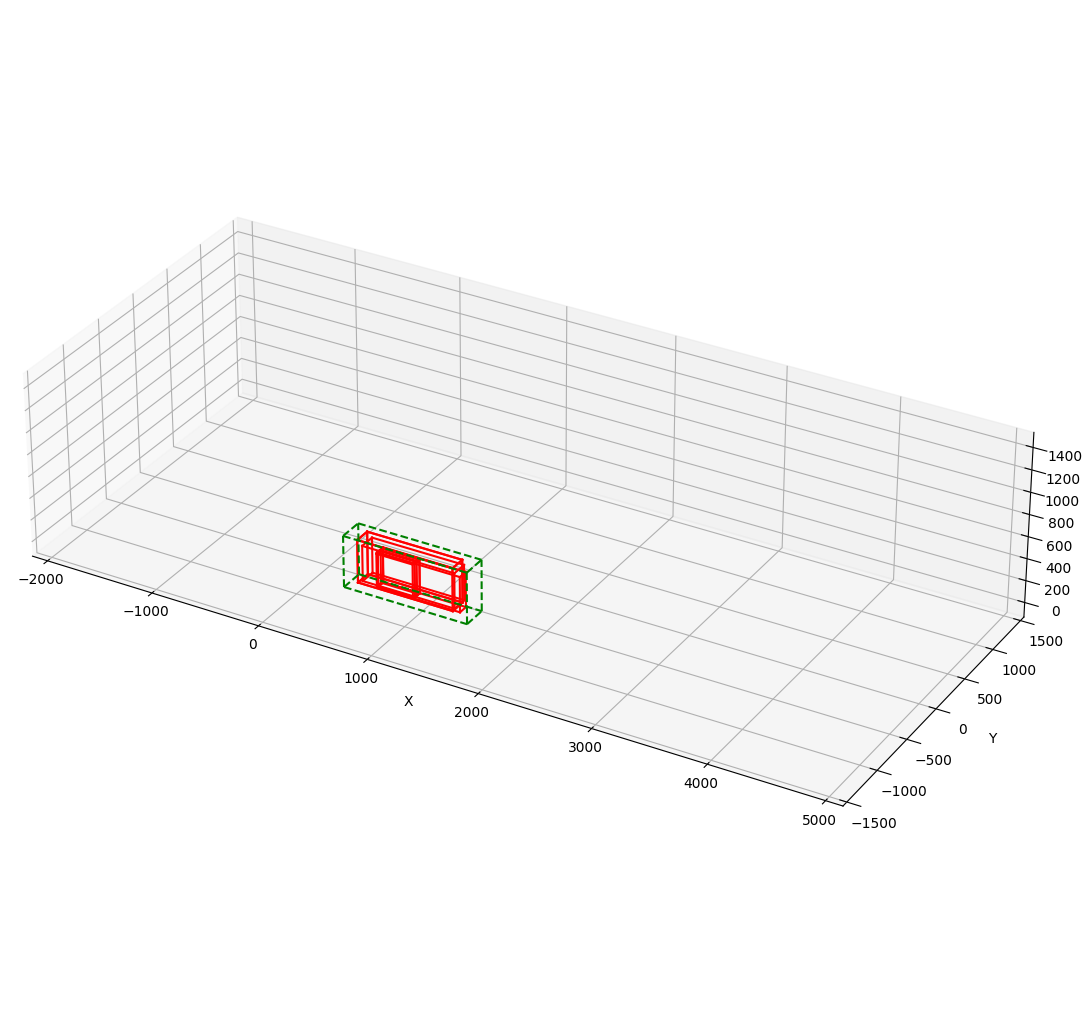

LI SONNENBLENDE
8 relevant parts found
Still 0 not relevant parts found


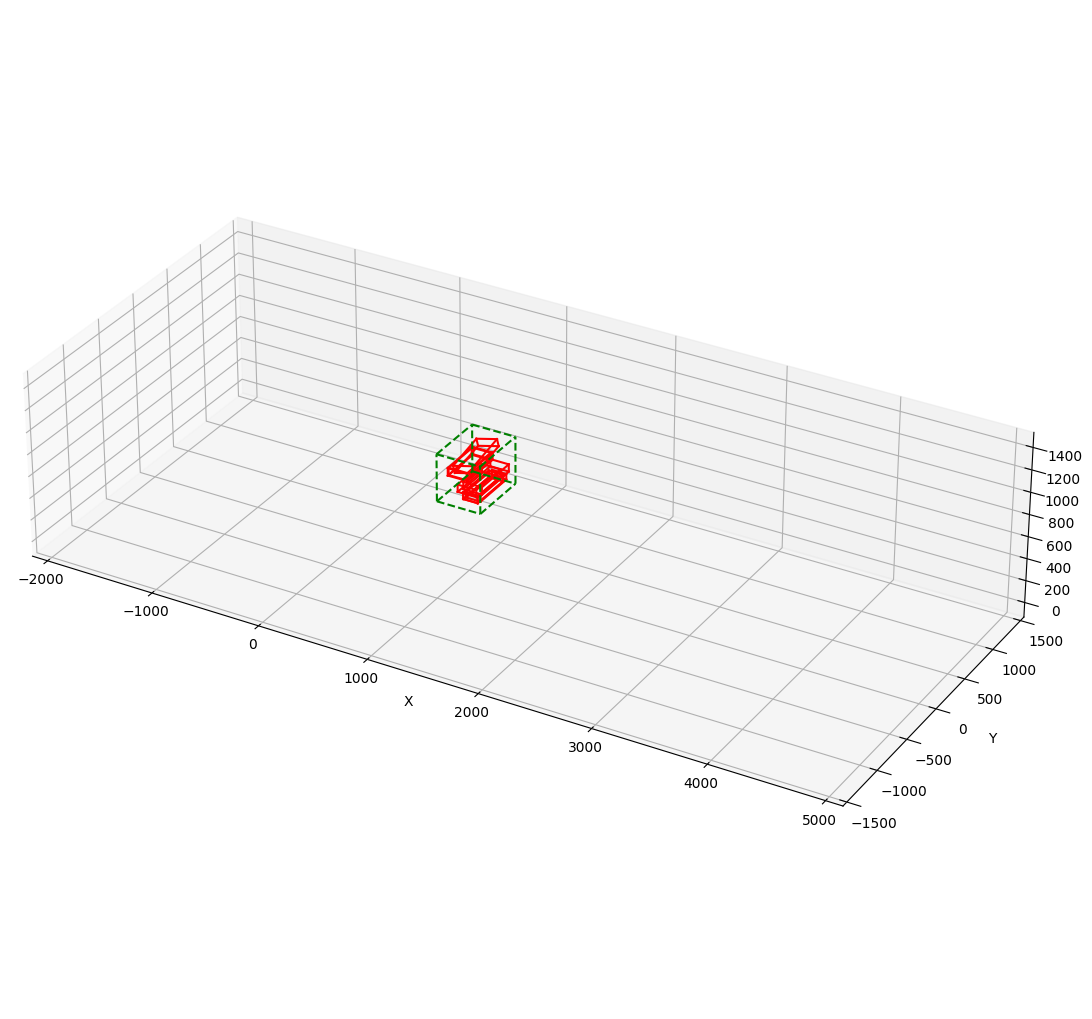

SEITENVERKLEIDUNG GEPAECKRAUM
7 relevant parts found
Still 0 not relevant parts found


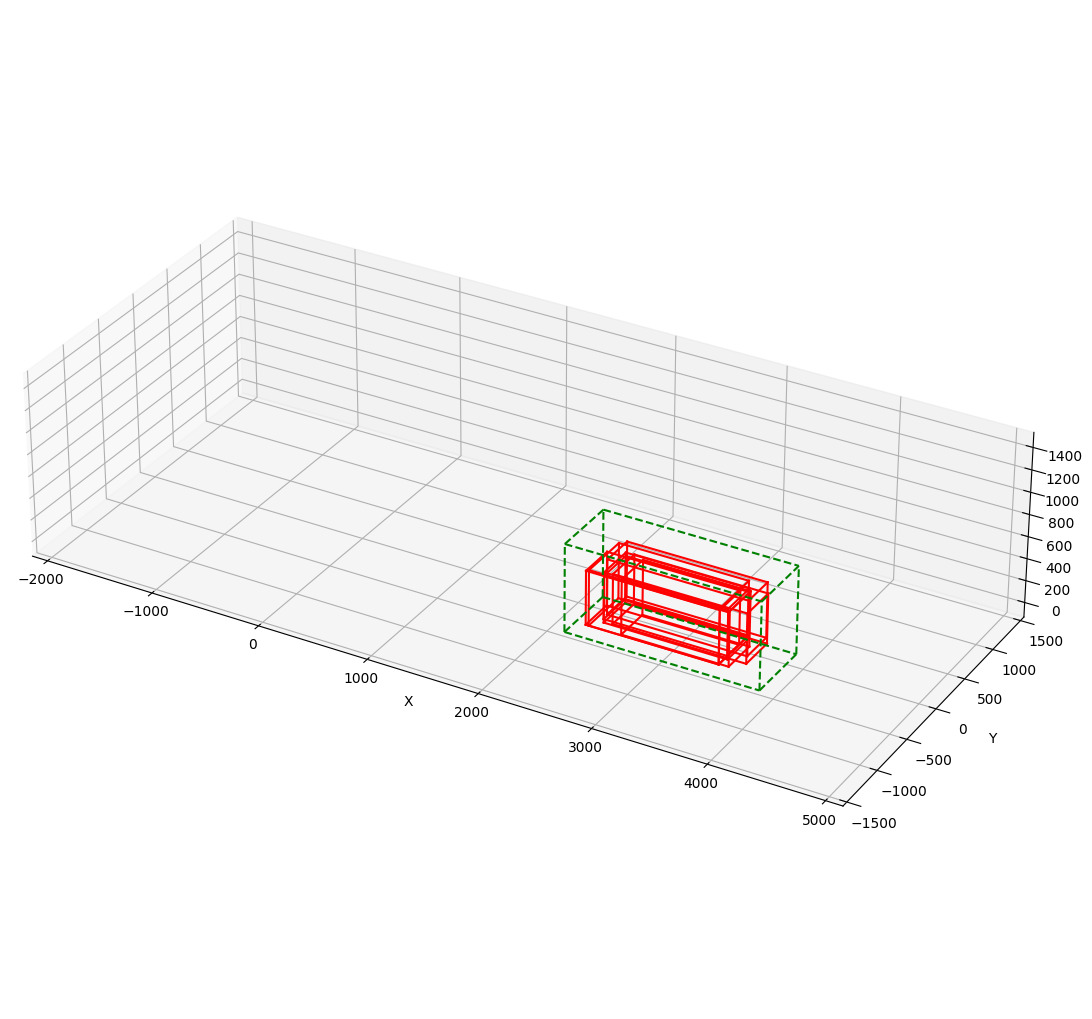

SPOILER
4 relevant parts found
Still 0 not relevant parts found


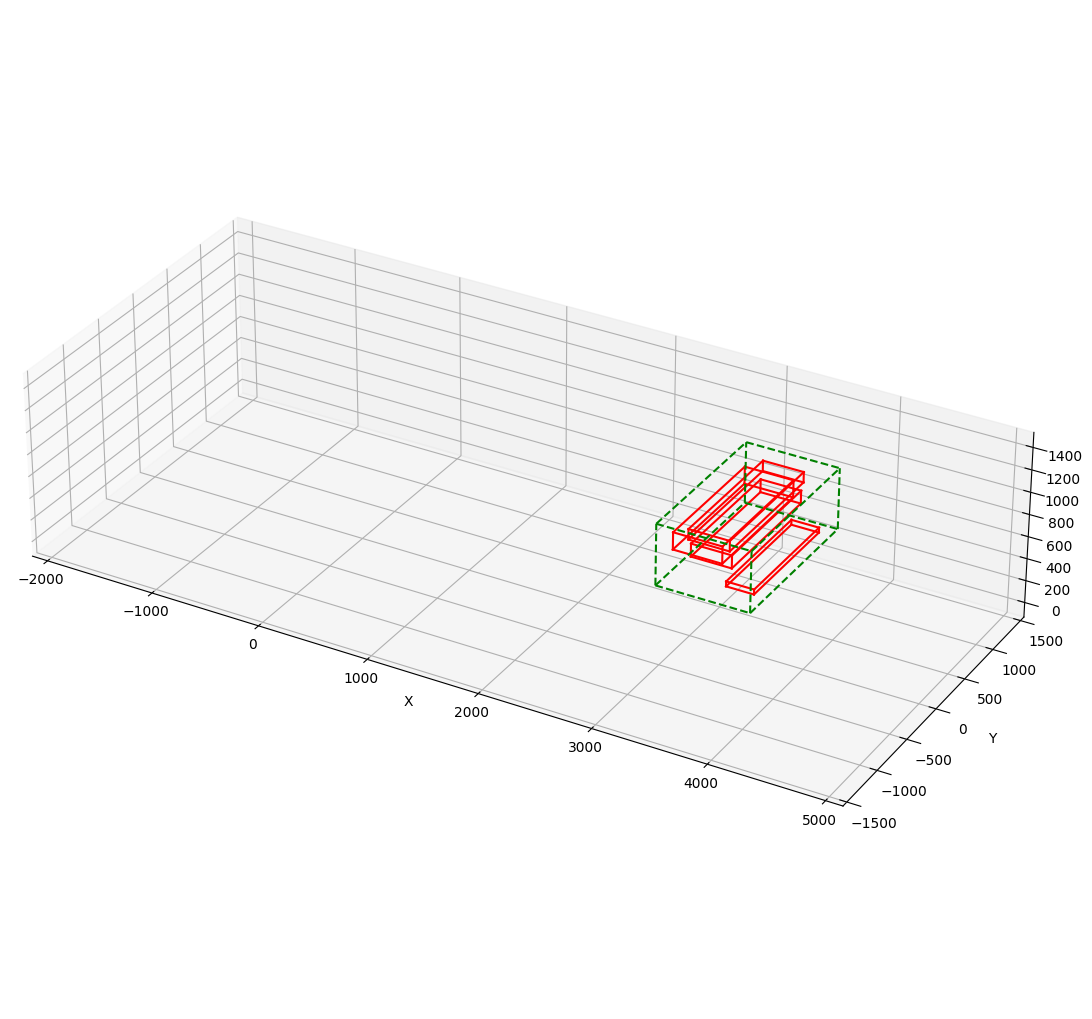

VERKLEIDUNG STOSSFAENGER
6 relevant parts found
Still 0 not relevant parts found


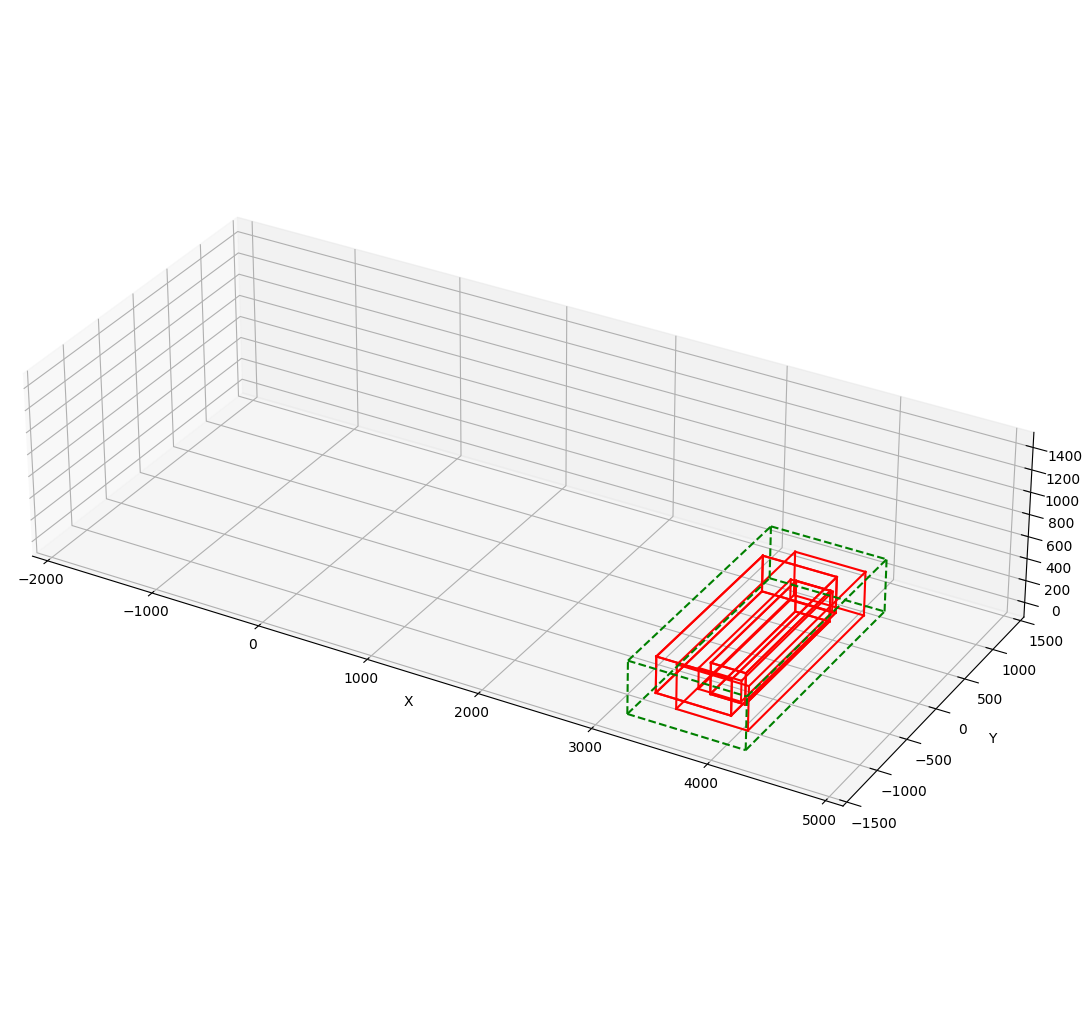

In [21]:
if __name__ == "__main__":
    
    main(path="../data/artificial_dataset_05062023_1656.xlsx",plot_preprocessed_data=True)

In [ ]:
"C:\Users\q617269\Desktop\Masterarbeit_Tobias\repos\master-thesis\data\artificial_dataset_05062023_1656.xlsx"